In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.annotate(str(round(model_time.value_in(units.Myr)))+" Myr", xy=(6.9, 9), xytext=(6.9, 9), 
                 weight='heavy', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
    #plt.title("Evolved to t = "+str(round(model_time.value_in(units.Myr)))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                com_pos = binary.center_of_mass()
                binary_momentum = binary.velocity * binary.mass.reshape((-1,1))
                L_b = (binary.position-com_pos).cross(binary_momentum).sum(axis=0)
                L_b = L_b.in_(units.pc*units.MSun*units.km/units.s)
                binary.thetaz = L_b[2] / L_b.length() # angle between the angular momentum and z-axis
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek


def get_hardness(BBH, particles, G=constants.G):
    
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    
    r2=(BBH.x[0]-BBH.x[1])**2+ \
       (BBH.y[0]-BBH.y[1])**2+ \
       (BBH.z[0]-BBH.z[1])**2 
    v2=(BBH.vx[0]-BBH.vx[1])**2+ \
       (BBH.vy[0]-BBH.vy[1])**2+ \
       (BBH.vz[0]-BBH.vz[1])**2 
    r=r2**0.5
    eb=G*(BBH.mass[0]+BBH.mass[1])/r-0.5*v2
    
    hardness = eb/average_Ek
    
    return hardness

## Initial condition

In [3]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

n_BHs = 300 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of BHs surrounding the SMBH
model_time = 0 | units.Myr

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, -2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.1
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
#     gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

# Name each BH
for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name
    
# Backup
SMBH0, BHdisk0, gasdisk0 = SMBH.copy(), BHdisk.copy(), gasdisk.copy()

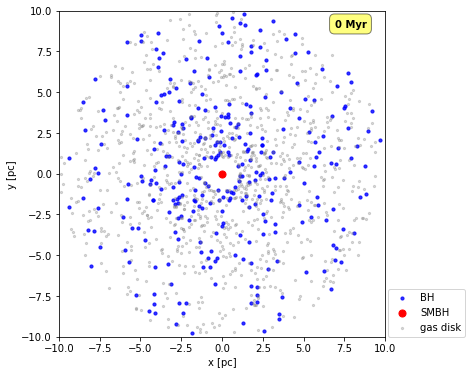

In [4]:
# The initial distribution of our objects
plot()
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
plt.show()

## BBH setup

In [41]:
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

for i in range(1, 300, 15):
    BBHi_1mass, BBHi_2mass = new_powerlaw_mass_distribution(2, 1.0|units.MSun, 
                                                          100.0|units.MSun, -2.35)
    
    bodies_test = bodies.copy()
    
    while True:
        np.random.seed()
        a = (np.random.rand(1)[0]*1000+1000) | units.au
        np.random.seed()
        e = np.random.rand(1)[0]/2
        BBHi = new_binary_from_orbital_elements(BBHi_1mass, BBHi_2mass, 
                                              a, e, G=constants.G)
        setattr(BBHi, "name", [f"BBH{i:d}_1", f"BBH{i:d}_2"])

        BBHi.position += BHdisk[BHdisk.name==f'BH{i:d}'].position
        BBHi.velocity += BHdisk[BHdisk.name==f'BH{i:d}'].velocity

        bodies_test.add_particles(BBHi)
        bodies_test = bodies_test[bodies_test.name!=f'BH{i:d}']
        hardness = get_hardness(BBHi, bodies_test)
        print(hardness)
        if (hardness>=1) & (hardness<=5):
            bodies = bodies_test.copy()
            break
        else:
            bodies_test = bodies.copy()

3.47517691034
1.66598747684
1.32473478541
3.22563404778
1.74363322328
1.54920213506
1.38499087962
2.27507859123
1.6760951218
1.90391489422
1.4257774229
1.417433941
1.7587119859
5.58733115197
9.69361183215
7.6012820428
6.06272358559
6.67425070299
5.89402535582
5.46369637888
8.07582187442
8.34376746174
5.11541655911
5.45191045301
7.4244118668
8.24993916684
6.39442275478
6.40528392142
8.65010278923
5.67616182163
7.47148148253
7.00240331869
5.46696783044
5.7438071519
9.47948039401
6.83796237308
8.6184783194
6.39593557001
5.57545329668
8.48453738492
7.32197236228
7.96645108119
5.08672714967
6.81596499245
5.25368029188
6.09285853169
6.70435236099
5.97723896359
5.76146138089
8.32363109712
5.54071791885
8.17126771375
5.91352058898
8.68615472838
5.76762430466
4.89199402818
1.56654076147
0.795408700395
0.794631764427
0.816302114064
1.10701123932
3.79579288398
5.40857390839
5.06754883053
7.39714530707
6.6931945071
7.46860374118
5.42148482969
8.10150485012
5.02454582383
5.658420259
6.93038784018
9

In [43]:
binaries = get_binaries(bodies, hardness=1)[0]

In [44]:
for b in binaries:
    print(b.hardness)

[ 1.3941209  1.3941209]
[ 1.28895055  1.28895055]
[ 1.89427809  1.89427809]
[ 1.10251114  1.10251114]
[ 3.44740284  3.44740284]
[ 1.66498441  1.66498441]
[ 1.74809765  1.74809765]
[ 3.20197591  3.20197591]
[ 1.37936767  1.37936767]
[ 1.731921  1.731921]
[ 1.31161509  1.31161509]
[ 1.56902373  1.56902373]
[ 1.64786595  1.64786595]
[ 1.5437681  1.5437681]
[ 4.89565626  4.89565626]
[ 1.20473302  1.20473302]
[ 1.73415939  1.73415939]
[ 3.79291033  3.79291033]
[ 1.41864511  1.41864511]
[ 2.26805753  2.26805753]
[ 1.22071009  1.22071009]
[ 4.9739168  4.9739168]


## Nbody simulation

In [48]:
gravity = ph4(converter1, number_of_workers=32)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[1:281]
BBH  = bodies[281:] 

gravity.particles.add_particles(bodies)
channel = gravity.particles.new_channel_to(bodies)

fig_root = "figure/Nbody/"

Evolved to t = 0 Myr 
BH number = 280
22 Binary found
Binary 1 is ['BBH166_1' 'BBH166_2'] with hardness = 1.39412090183 d = 1482.44545787 au v = 1.40740799041 kms radius = 4.43790245662 parsec and theta_z = 1.0
Binary 2 is ['BH98' 'BH2'] with hardness = 1.28895054847 d = 2668.76129435 au v = 0.0708685678518 kms radius = 4.53588616972 parsec and theta_z = -0.583101063417
Binary 3 is ['BBH136_1' 'BBH136_2'] with hardness = 1.89427808641 d = 1800.4193125 au v = 1.63571131736 kms radius = 5.99478960958 parsec and theta_z = 1.0
Binary 4 is ['BBH226_1' 'BBH226_2'] with hardness = 1.10251114096 d = 979.650451899 au v = 1.57778003147 kms radius = 9.50088758373 parsec and theta_z = 1.0
Binary 5 is ['BBH1_1' 'BBH1_2'] with hardness = 3.44740284247 d = 1297.8933108 au v = 2.4570626984 kms radius = 4.20471249404 parsec and theta_z = 1.0
Binary 6 is ['BBH121_1' 'BBH121_2'] with hardness = 1.66498440725 d = 864.118891737 au v = 2.02986495929 kms radius = 4.30958496876 parsec and theta_z = 1.0
Binary

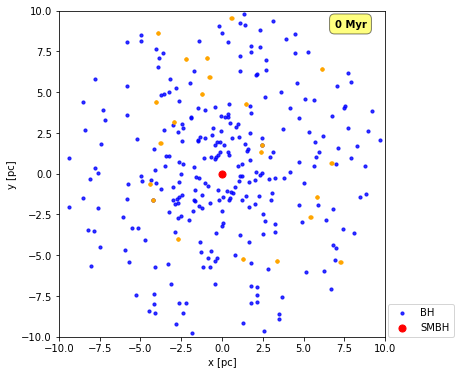



Evolved to t = 1 Myr 
BH number = 280
22 Binary found
Binary 1 is ['BBH181_1' 'BBH181_2'] with hardness = 1.73394017735 d = 1308.57296776 au v = 1.68836890709 kms radius = 7.15329359013 parsec and theta_z = 0.999999988725
Binary 2 is ['BBH46_2' 'BBH46_1'] with hardness = 3.20152643726 d = 2067.49477998 au v = 1.73626389102 kms radius = 7.36801610086 parsec and theta_z = 0.999999998684
Binary 3 is ['BBH151_2' 'BBH151_1'] with hardness = 1.42524981766 d = 1244.06934916 au v = 1.14642787665 kms radius = 6.00910172065 parsec and theta_z = 0.999999780755
Binary 4 is ['BBH16_2' 'BBH16_1'] with hardness = 1.65098683808 d = 1654.25323065 au v = 1.3173260982 kms radius = 5.38391895909 parsec and theta_z = 0.999999972309
Binary 5 is ['BBH241_2' 'BBH241_1'] with hardness = 3.80167593812 d = 1890.97464595 au v = 1.38646789702 kms radius = 6.03678349518 parsec and theta_z = 0.999999975693
Binary 6 is ['BBH76_2' 'BBH76_1'] with hardness = 1.5290863873 d = 1593.95930707 au v = 1.52275068495 kms rad

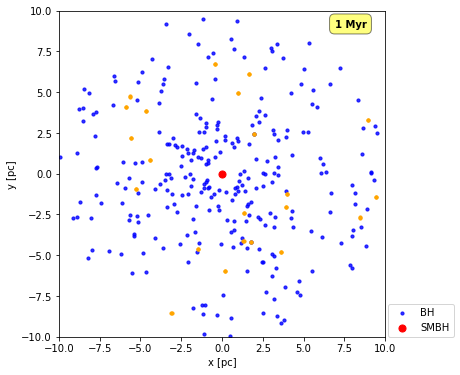



Evolved to t = 2 Myr 
BH number = 280
23 Binary found
Binary 1 is ['BBH256_2' 'BBH256_1'] with hardness = 5.12238314929 d = 2237.14532882 au v = 2.25521038348 kms radius = 9.07372392361 parsec and theta_z = 0.99999993094
Binary 2 is ['BH180' 'BH246'] with hardness = 0.552031237665 d = 13664.6826697 au v = 0.0987165570049 kms radius = 8.78698028338 parsec and theta_z = 0.768860640317
Binary 3 is ['BBH46_2' 'BBH46_1'] with hardness = 3.2997292699 d = 1896.14110137 au v = 1.91014672996 kms radius = 7.37536595467 parsec and theta_z = 0.999999997477
Binary 4 is ['BBH181_2' 'BBH181_1'] with hardness = 1.78350877208 d = 1742.39963703 au v = 1.25622523905 kms radius = 7.11717652159 parsec and theta_z = 0.99999996083
Binary 5 is ['BBH271_1' 'BBH271_2'] with hardness = 1.26421469378 d = 1396.0329879 au v = 1.21387872321 kms radius = 6.7499633039 parsec and theta_z = 0.999999073809
Binary 6 is ['BBH61_2' 'BBH61_1'] with hardness = 1.7856878605 d = 1950.06499188 au v = 1.43584259636 kms radius =

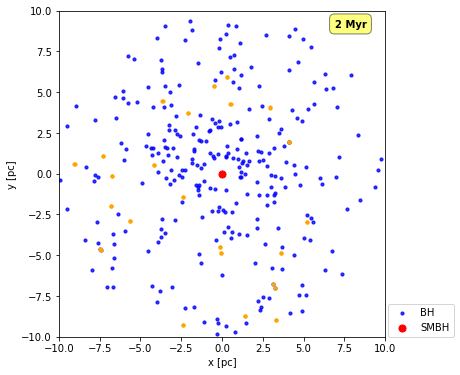



Evolved to t = 3 Myr 
BH number = 280
20 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 1.61114187641 d = 2000.92741315 au v = 1.2366246788 kms radius = 9.59958502734 parsec and theta_z = 0.999999963718
Binary 2 is ['BBH226_1' 'BBH226_2'] with hardness = 1.13584347895 d = 992.997196174 au v = 1.56017474497 kms radius = 9.41087097173 parsec and theta_z = 0.999999756923
Binary 3 is ['BBH106_1' 'BBH106_2'] with hardness = 2.33594520507 d = 1125.03519142 au v = 1.75403737043 kms radius = 8.85201082121 parsec and theta_z = 0.999999954412
Binary 4 is ['BBH46_2' 'BBH46_1'] with hardness = 3.2873536008 d = 2186.37599629 au v = 1.61982733107 kms radius = 7.3699139782 parsec and theta_z = 0.999999996117
Binary 5 is ['BBH241_2' 'BBH241_1'] with hardness = 3.90320552263 d = 1711.00124513 au v = 1.62552609961 kms radius = 6.02419449433 parsec and theta_z = 0.999999753204
Binary 6 is ['BH98' 'BH2'] with hardness = 1.33663194313 d = 1132.69999758 au v = 1.506340311 kms radius = 4.

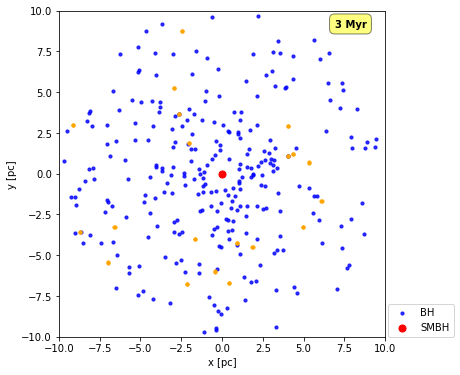



Evolved to t = 4 Myr 
BH number = 280
22 Binary found
Binary 1 is ['BBH106_1' 'BBH106_2'] with hardness = 2.33751151468 d = 1087.45755705 au v = 1.81256593501 kms radius = 8.86775091194 parsec and theta_z = 0.999999917539
Binary 2 is ['BBH136_2' 'BBH136_1'] with hardness = 1.95284092898 d = 1748.68274138 au v = 1.68035050391 kms radius = 5.74519695101 parsec and theta_z = 0.999989277126
Binary 3 is ['BH279' 'BBH1_1'] with hardness = 4.25650674631 d = 2713.87891288 au v = 0.559647757386 kms radius = 4.18900811634 parsec and theta_z = 0.855496721338
Binary 4 is ['BBH46_1' 'BBH46_2'] with hardness = 3.29986704515 d = 1487.87925239 au v = 2.40688126474 kms radius = 7.34907130251 parsec and theta_z = 0.999999986543
Binary 5 is ['BH98' 'BH2'] with hardness = 1.34653460677 d = 2581.77895802 au v = 0.19114804253 kms radius = 4.53194294793 parsec and theta_z = 0.0197756482371
Binary 6 is ['BBH61_1' 'BBH61_2'] with hardness = 1.77699617346 d = 1936.2537881 au v = 1.45037345444 kms radius = 6.3

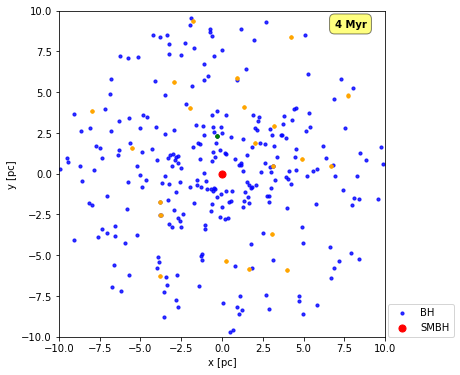



Evolved to t = 5 Myr 
BH number = 280
20 Binary found
Binary 1 is ['BBH16_1' 'BBH16_2'] with hardness = 1.72885795339 d = 1662.90251135 au v = 1.30069947771 kms radius = 5.38932999724 parsec and theta_z = 0.999999809234
Binary 2 is ['BBH121_2' 'BBH121_1'] with hardness = 1.72779426273 d = 1661.49198329 au v = 1.0510774771 kms radius = 4.2977950374 parsec and theta_z = 0.999999577758
Binary 3 is ['BBH76_1' 'BBH76_2'] with hardness = 1.61396651032 d = 1801.41486367 au v = 1.33631227253 kms radius = 4.45682931695 parsec and theta_z = 0.999991684696
Binary 4 is ['BBH166_1' 'BBH166_2'] with hardness = 2.2733704719 d = 874.941101412 au v = 1.89180143401 kms radius = 4.32871999116 parsec and theta_z = 0.998956400995
Binary 5 is ['BBH61_2' 'BBH61_1'] with hardness = 1.79302585049 d = 1848.10648848 au v = 1.51960550626 kms radius = 6.29716852084 parsec and theta_z = 0.999999784692
Binary 6 is ['BBH31_1' 'BBH31_2'] with hardness = 1.36191792646 d = 1660.48952888 au v = 1.25497920696 kms radius

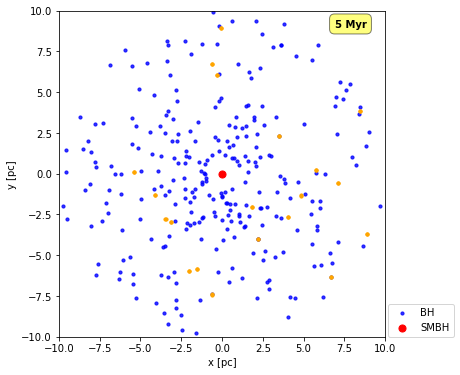



Evolved to t = 6 Myr 
BH number = 280
20 Binary found
Binary 1 is ['BBH271_1' 'BBH271_2'] with hardness = 1.26322774222 d = 1355.37127781 au v = 1.25247332067 kms radius = 6.70881628755 parsec and theta_z = 0.999992426728
Binary 2 is ['BH222' 'BBH256_2'] with hardness = 3.36478451551 d = 6531.92662949 au v = 1.09116459925 kms radius = 9.16586072973 parsec and theta_z = -0.451471374321
Binary 3 is ['BBH136_1' 'BBH136_2'] with hardness = 1.97159643493 d = 1889.36187203 au v = 1.55202896582 kms radius = 5.73453008286 parsec and theta_z = 0.999980353524
Binary 4 is ['BH279' 'BBH1_1'] with hardness = 4.31069044036 d = 445.51912928 au v = 5.4040892118 kms radius = 4.1973159955 parsec and theta_z = 0.9357716579
Binary 5 is ['BBH211_2' 'BBH211_1'] with hardness = 1.617993375 d = 2095.43617735 au v = 1.16777271112 kms radius = 9.46023550009 parsec and theta_z = 0.999999931627
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 5.0758113815 d = 2150.44949936 au v = 2.32628534219 kms radius = 2

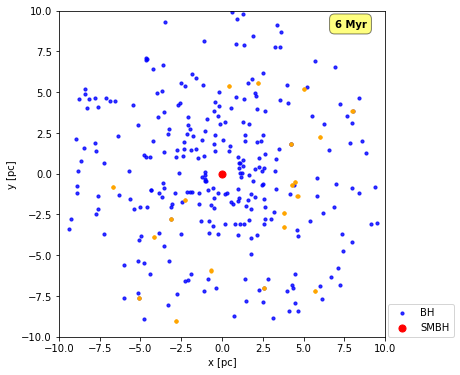



Evolved to t = 7 Myr 
BH number = 280
20 Binary found
Binary 1 is ['BBH211_1' 'BBH211_2'] with hardness = 1.61145286199 d = 1721.34438101 au v = 1.45083981696 kms radius = 9.1071307278 parsec and theta_z = 0.999999906362
Binary 2 is ['BBH256_2' 'BH222'] with hardness = 3.35467834157 d = 2157.67351654 au v = 3.49358185233 kms radius = 9.21932201682 parsec and theta_z = -0.361040292701
Binary 3 is ['BBH226_1' 'BBH226_2'] with hardness = 1.36667599962 d = 696.996653962 au v = 1.94504724418 kms radius = 9.01605857401 parsec and theta_z = 0.998888959053
Binary 4 is ['BBH61_2' 'BBH61_1'] with hardness = 1.7862882252 d = 1809.61666963 au v = 1.54627320724 kms radius = 6.27887661897 parsec and theta_z = 0.999999462186
Binary 5 is ['BBH121_1' 'BBH121_2'] with hardness = 1.72752118426 d = 1045.38098324 au v = 1.73448373809 kms radius = 4.25963584551 parsec and theta_z = 0.999999961279
Binary 6 is ['BBH31_2' 'BBH31_1'] with hardness = 1.36047593723 d = 1648.55430932 au v = 1.25801277627 kms rad

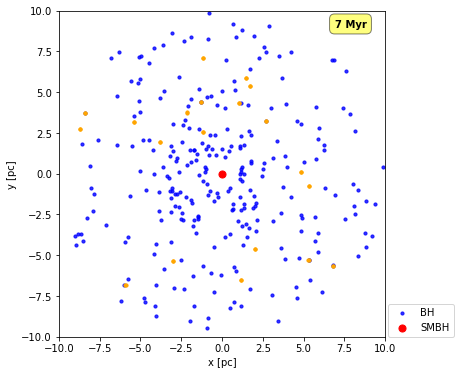



Evolved to t = 8 Myr 
BH number = 280
21 Binary found
Binary 1 is ['BBH226_2' 'BBH226_1'] with hardness = 1.36779977259 d = 1358.18236019 au v = 1.04889322938 kms radius = 9.05137902737 parsec and theta_z = 0.998898442004
Binary 2 is ['BBH181_2' 'BBH181_1'] with hardness = 1.78492548579 d = 1842.32703014 au v = 1.16883912259 kms radius = 7.19347714731 parsec and theta_z = 0.999999531283
Binary 3 is ['BH2' 'BH98'] with hardness = 0.75028377135 d = 3412.26746872 au v = 0.60460654907 kms radius = 4.55325251941 parsec and theta_z = -0.0141848273045
Binary 4 is ['BBH76_2' 'BBH76_1'] with hardness = 1.63598834731 d = 1598.52947714 au v = 1.49064197807 kms radius = 4.4277475709 parsec and theta_z = 0.999997265004
Binary 5 is ['BBH241_2' 'BBH241_1'] with hardness = 2.76803239887 d = 1550.17326157 au v = 2.20481325458 kms radius = 5.94556406898 parsec and theta_z = 0.219320755081
Binary 6 is ['BH279' 'BBH1_1'] with hardness = 4.32447195674 d = 2159.2482238 au v = 1.29685632462 kms radius = 4.

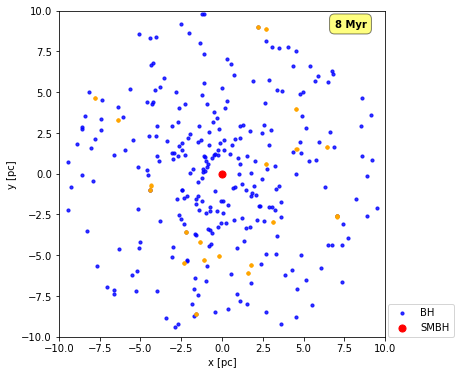



Evolved to t = 9 Myr 
BH number = 280
21 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.10638160873 d = 2114.852595 au v = 0.356868649742 kms radius = 8.73313574805 parsec and theta_z = 0.711000832211
Binary 2 is ['BBH31_2' 'BBH31_1'] with hardness = 1.35891154487 d = 1812.4413912 au v = 1.13755510958 kms radius = 6.04948333031 parsec and theta_z = 0.999877600728
Binary 3 is ['BBH16_2' 'BBH16_1'] with hardness = 1.73506547851 d = 1671.18763391 au v = 1.28551271733 kms radius = 5.37399561668 parsec and theta_z = 0.999999790969
Binary 4 is ['BBH181_1' 'BBH181_2'] with hardness = 1.53071828088 d = 1860.12622699 au v = 1.28837445474 kms radius = 7.00965928733 parsec and theta_z = 0.999996662373
Binary 5 is ['BBH136_2' 'BBH136_1'] with hardness = 1.9808877954 d = 1951.5449316 au v = 1.49824044074 kms radius = 5.56929492521 parsec and theta_z = 0.999966000671
Binary 6 is ['BBH91_1' 'BBH91_2'] with hardness = 1.45277306989 d = 975.783405307 au v = 1.53920942299 kms radius =

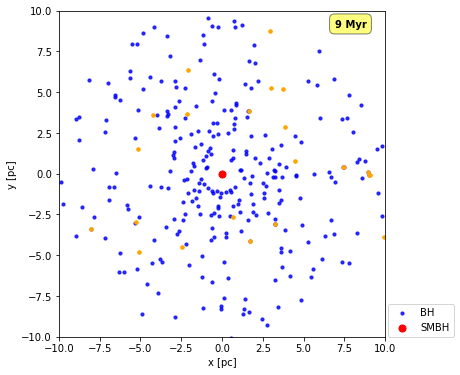



Evolved to t = 10 Myr 
BH number = 280
19 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.09254943883 d = 2095.80311109 au v = 0.400540190212 kms radius = 8.75937225791 parsec and theta_z = 0.817339519737
Binary 2 is ['BBH271_2' 'BBH271_1'] with hardness = 1.26825201272 d = 1287.01846634 au v = 1.31299382804 kms radius = 6.73160986259 parsec and theta_z = 0.999983239156
Binary 3 is ['BBH61_2' 'BBH61_1'] with hardness = 1.77510383201 d = 1938.71219341 au v = 1.44708182893 kms radius = 6.25136077424 parsec and theta_z = 0.999999388201
Binary 4 is ['BBH211_2' 'BBH211_1'] with hardness = 2.67730600837 d = 1584.34192665 au v = 1.05481853747 kms radius = 9.53897495615 parsec and theta_z = 0.996621802091
Binary 5 is ['BH72' 'BBH91_2'] with hardness = 1.03953479913 d = 2453.89908983 au v = 0.886247739487 kms radius = 5.2027644414 parsec and theta_z = 0.990118781978
Binary 6 is ['BBH241_1' 'BBH241_2'] with hardness = 2.76701055829 d = 1752.55288896 au v = 1.97260169401 kms rad

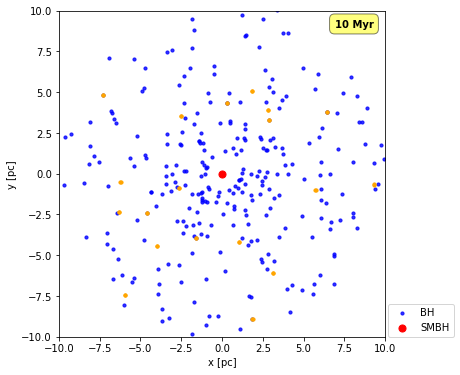



Evolved to t = 11 Myr 
BH number = 280
20 Binary found
Binary 1 is ['BH272' 'BBH256_2'] with hardness = 0.829460620615 d = 12312.5568948 au v = 1.02048732239 kms radius = 9.21888342536 parsec and theta_z = -0.808830681793
Binary 2 is ['BH222' 'BBH256_2'] with hardness = 3.31443302033 d = 5551.73364246 au v = 1.49236573421 kms radius = 9.22249999025 parsec and theta_z = -0.398725605599
Binary 3 is ['BBH136_2' 'BBH136_1'] with hardness = 1.98869115028 d = 1777.60270369 au v = 1.64413689262 kms radius = 5.70068057388 parsec and theta_z = 0.999966322172
Binary 4 is ['BBH91_2' 'BH72'] with hardness = 1.09038139819 d = 1741.11174165 au v = 1.26147189891 kms radius = 5.20899068093 parsec and theta_z = 0.990297059399
Binary 5 is ['BH5' 'BBH76_2'] with hardness = 1.023537587 d = 2922.65943415 au v = 0.542354949247 kms radius = 4.48658660509 parsec and theta_z = 0.640549499745
Binary 6 is ['BH2' 'BH98'] with hardness = 0.635414400009 d = 2612.77123894 au v = 0.957678039713 kms radius = 4.39375

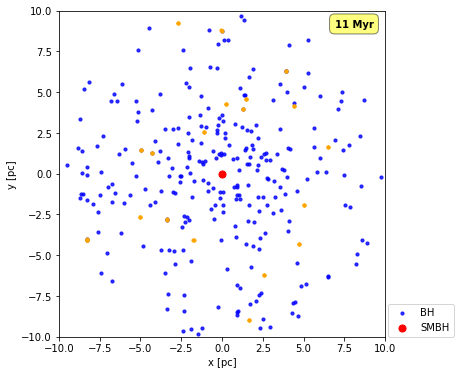



Evolved to t = 12 Myr 
BH number = 280
21 Binary found
Binary 1 is ['BBH226_2' 'BBH226_1'] with hardness = 1.37953278342 d = 1533.42775077 au v = 0.881575986541 kms radius = 8.98262674225 parsec and theta_z = 0.998617388497
Binary 2 is ['BH222' 'BBH256_2'] with hardness = 3.60730849973 d = 4473.00759359 au v = 1.84806773821 kms radius = 9.25475965111 parsec and theta_z = -0.449073402255
Binary 3 is ['BBH241_2' 'BBH241_1'] with hardness = 2.78021484318 d = 3581.93077855 au v = 0.366774951379 kms radius = 5.96908542206 parsec and theta_z = 0.784215667119
Binary 4 is ['BBH91_2' 'BH72'] with hardness = 1.0679859157 d = 2896.43033176 au v = 0.665099693239 kms radius = 5.16732400091 parsec and theta_z = 0.990997983721
Binary 5 is ['BBH16_2' 'BBH16_1'] with hardness = 1.7524216386 d = 1516.0521065 au v = 1.42633642877 kms radius = 5.38437712293 parsec and theta_z = 0.999999817352
Binary 6 is ['BH279' 'BBH1_1'] with hardness = 7.84352643362 d = 975.019313272 au v = 2.44972861096 kms radius =

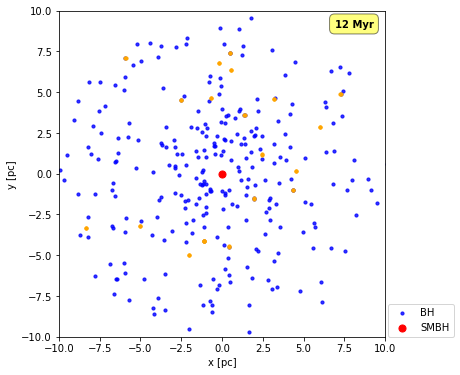



Evolved to t = 13 Myr 
BH number = 280
18 Binary found
Binary 1 is ['BBH181_1' 'BBH181_2'] with hardness = 1.52182521818 d = 2178.12252351 au v = 1.07169426733 kms radius = 7.01231461225 parsec and theta_z = 0.999997321151
Binary 2 is ['BBH226_2' 'BH86'] with hardness = 0.835861572792 d = 3458.87749095 au v = 0.538279210058 kms radius = 9.15933535998 parsec and theta_z = 0.653033734242
Binary 3 is ['BBH16_1' 'BBH16_2'] with hardness = 1.74903534451 d = 1642.60879037 au v = 1.30501224902 kms radius = 5.36082456134 parsec and theta_z = 0.999999846452
Binary 4 is ['BBH61_2' 'BBH61_1'] with hardness = 1.78810645441 d = 1934.06558908 au v = 1.44967494755 kms radius = 6.24015290813 parsec and theta_z = 0.999999544459
Binary 5 is ['BBH271_1' 'BBH271_2'] with hardness = 1.27770021971 d = 1441.48468288 au v = 1.16827997837 kms radius = 6.67176084502 parsec and theta_z = 0.999977901547
Binary 6 is ['BH253' 'BH152'] with hardness = 2.99632526008 d = 3519.13832982 au v = 0.754272309268 kms radiu

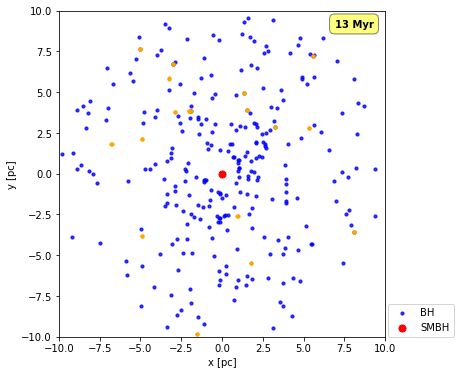



Evolved to t = 14 Myr 
BH number = 280
18 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 2.69894564578 d = 1561.38997078 au v = 1.08486456368 kms radius = 9.40895373392 parsec and theta_z = 0.995249457624
Binary 2 is ['BH253' 'BH152'] with hardness = 3.00410142813 d = 3592.89636456 au v = 0.689701948616 kms radius = 7.35852677517 parsec and theta_z = 0.582390951289
Binary 3 is ['BBH271_1' 'BBH271_2'] with hardness = 1.27892395979 d = 1407.80686007 au v = 1.19868802115 kms radius = 6.73847273922 parsec and theta_z = 0.999977716681
Binary 4 is ['BBH241_1' 'BBH241_2'] with hardness = 2.77669734564 d = 1884.53875787 au v = 1.84045352345 kms radius = 6.01062495777 parsec and theta_z = 0.209168066174
Binary 5 is ['BH285' 'BH66'] with hardness = 0.543279070215 d = 23912.4773792 au v = 0.541706593149 kms radius = 7.88031879306 parsec and theta_z = -0.844654550469
Binary 6 is ['BBH136_2' 'BBH136_1'] with hardness = 1.53008311097 d = 2131.12530368 au v = 1.55469762594 kms rad

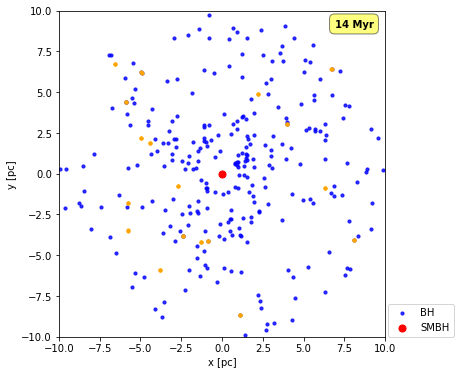



Evolved to t = 15 Myr 
BH number = 280
17 Binary found
Binary 1 is ['BH152' 'BH253'] with hardness = 2.9689617607 d = 513.662973828 au v = 5.09531199075 kms radius = 7.34199305786 parsec and theta_z = 0.447694659997
Binary 2 is ['BH180' 'BBH106_2'] with hardness = 3.10680702258 d = 408.305089026 au v = 4.12021606153 kms radius = 8.7210878214 parsec and theta_z = 0.349497061222
Binary 3 is ['BBH286_2' 'BBH286_1'] with hardness = 1.79523702337 d = 1141.44025771 au v = 1.82527444028 kms radius = 4.8139189242 parsec and theta_z = 0.999999983077
Binary 4 is ['BBH61_1' 'BBH61_2'] with hardness = 1.77838110134 d = 1923.32731591 au v = 1.45552544359 kms radius = 6.33024543913 parsec and theta_z = 0.999999740791
Binary 5 is ['BH222' 'BBH256_2'] with hardness = 3.46034650796 d = 6594.82594671 au v = 0.994619206369 kms radius = 9.17882283217 parsec and theta_z = -0.633911723866
Binary 6 is ['BH48' 'BBH1_1'] with hardness = 9.42288091148 d = 827.61382735 au v = 2.86047010422 kms radius = 4.16344

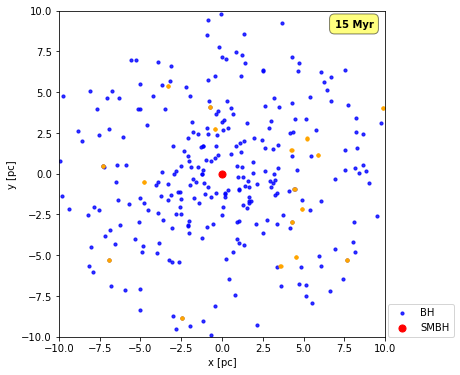



Evolved to t = 16 Myr 
BH number = 280
17 Binary found
Binary 1 is ['BBH256_2' 'BH222'] with hardness = 3.47166196968 d = 942.570923731 au v = 5.76804636975 kms radius = 9.25367715502 parsec and theta_z = -0.70504837709
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.12314937953 d = 1854.03257801 au v = 0.81379373954 kms radius = 8.74714724919 parsec and theta_z = 0.272147373975
Binary 3 is ['BH152' 'BH253'] with hardness = 3.06479417584 d = 1440.82764274 au v = 2.59386574545 kms radius = 7.70185565388 parsec and theta_z = 0.313045327677
Binary 4 is ['BBH241_2' 'BBH241_1'] with hardness = 2.75941632938 d = 2120.50467409 au v = 1.62041682785 kms radius = 6.03814608899 parsec and theta_z = 0.262116674664
Binary 5 is ['BBH166_2' 'BBH166_1'] with hardness = 2.27058444115 d = 1300.6178932 au v = 1.20598986873 kms radius = 4.2612773317 parsec and theta_z = 0.999234630799
Binary 6 is ['BBH286_2' 'BBH286_1'] with hardness = 1.80983224715 d = 1127.75780642 au v = 1.84190514869 kms radius =

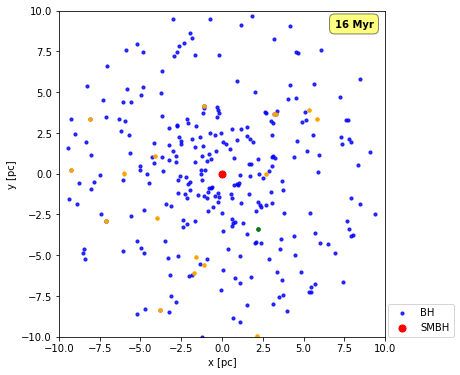



Evolved to t = 17 Myr 
BH number = 280
19 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.838180354823 d = 1354.53551839 au v = 1.5394735907 kms radius = 9.10075413349 parsec and theta_z = 0.468095566268
Binary 2 is ['BBH211_2' 'BBH211_1'] with hardness = 2.69486035695 d = 1632.76212003 au v = 0.986740757718 kms radius = 9.27691801716 parsec and theta_z = 0.994120857803
Binary 3 is ['BH253' 'BH152'] with hardness = 3.07779733975 d = 2868.28887673 au v = 1.20288628139 kms radius = 7.69013036791 parsec and theta_z = 0.300431924844
Binary 4 is ['BBH16_2' 'BBH16_1'] with hardness = 1.16831462683 d = 3211.24275917 au v = 0.724695681994 kms radius = 5.38989742697 parsec and theta_z = 0.581900584348
Binary 5 is ['BBH271_2' 'BBH271_1'] with hardness = 1.27990791146 d = 1411.61390597 au v = 1.1930082964 kms radius = 6.64381388805 parsec and theta_z = 0.999979470748
Binary 6 is ['BH282' 'BBH1_1'] with hardness = 46.9949219082 d = 68.4064303899 au v = 12.961926047 kms radius = 3.

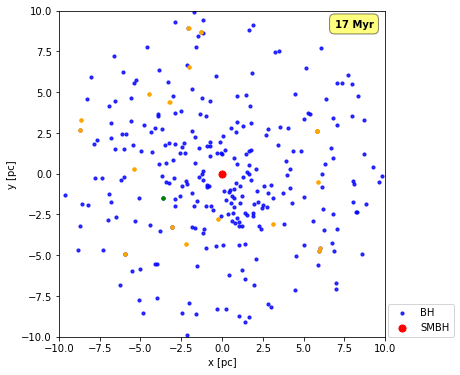



Evolved to t = 18 Myr 
BH number = 280
19 Binary found
Binary 1 is ['BBH181_1' 'BBH181_2'] with hardness = 1.53073677918 d = 1754.4124824 au v = 1.37121163089 kms radius = 7.03993970625 parsec and theta_z = 0.999998703799
Binary 2 is ['BBH241_2' 'BBH241_1'] with hardness = 2.53478047294 d = 3066.82690866 au v = 1.02008070102 kms radius = 5.94778548198 parsec and theta_z = 0.395971933243
Binary 3 is ['BBH61_1' 'BBH61_2'] with hardness = 1.36816212848 d = 816.828249668 au v = 2.93001381815 kms radius = 6.31181645222 parsec and theta_z = -0.913928081872
Binary 4 is ['BBH271_1' 'BBH271_2'] with hardness = 1.2856643422 d = 1248.38989277 au v = 1.34803262963 kms radius = 6.74128574765 parsec and theta_z = 0.999982480008
Binary 5 is ['BH152' 'BH253'] with hardness = 3.0819269177 d = 1050.43332906 au v = 3.26590655663 kms radius = 7.68463819338 parsec and theta_z = 0.323772012891
Binary 6 is ['BBH196_1' 'BH99'] with hardness = 1.64430148284 d = 4027.46360638 au v = 1.7580918762 kms radius = 

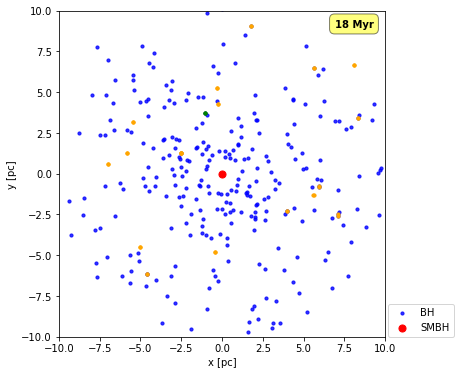



Evolved to t = 19 Myr 
BH number = 280
16 Binary found
Binary 1 is ['BBH136_1' 'BBH136_2'] with hardness = 1.51920803812 d = 2856.98562511 au v = 1.14629079173 kms radius = 5.63750632775 parsec and theta_z = 0.999974712727
Binary 2 is ['BBH181_2' 'BBH181_1'] with hardness = 1.60294397025 d = 927.281332697 au v = 2.2731368768 kms radius = 7.01779650342 parsec and theta_z = 0.99997910495
Binary 3 is ['BH253' 'BH152'] with hardness = 2.95250648823 d = 2980.95114491 au v = 1.17707853808 kms radius = 7.64527317518 parsec and theta_z = 0.346044523631
Binary 4 is ['BBH166_1' 'BBH166_2'] with hardness = 2.27444948774 d = 806.206632027 au v = 2.02333701571 kms radius = 4.34677800747 parsec and theta_z = 0.998872239881
Binary 5 is ['BH2' 'BH98'] with hardness = 0.642153516762 d = 3584.55616595 au v = 0.661620017595 kms radius = 4.31471336537 parsec and theta_z = -0.00814186233369
Binary 6 is ['BBH61_2' 'BBH61_1'] with hardness = 1.32972117398 d = 3522.8321198 au v = 0.840157046225 kms radius =

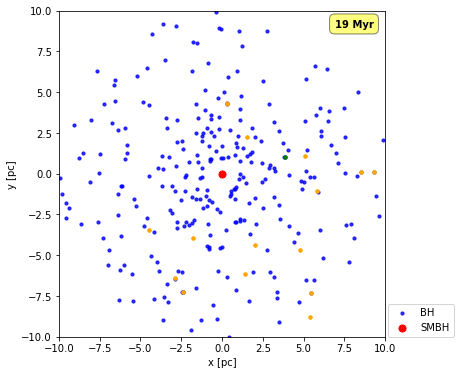



Evolved to t = 20 Myr 
BH number = 280
17 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 2.67998063326 d = 1590.73976823 au v = 1.0424177713 kms radius = 9.25734087532 parsec and theta_z = 0.99361176377
Binary 2 is ['BBH241_1' 'BBH241_2'] with hardness = 3.12538272135 d = 1770.62350397 au v = 1.83213649479 kms radius = 5.99098990346 parsec and theta_z = 0.718002305764
Binary 3 is ['BH222' 'BBH256_2'] with hardness = 2.68754159405 d = 4313.23061137 au v = 2.19587070193 kms radius = 9.20072428903 parsec and theta_z = -0.712072278124
Binary 4 is ['BH98' 'BH2'] with hardness = 0.717246310215 d = 4234.83229707 au v = 0.386461372013 kms radius = 4.4371280009 parsec and theta_z = -0.21877860015
Binary 5 is ['BH152' 'BH253'] with hardness = 2.95002924538 d = 3619.82582832 au v = 0.692218342161 kms radius = 7.63336759237 parsec and theta_z = 0.411330894219
Binary 6 is ['BBH136_2' 'BBH136_1'] with hardness = 1.54156851822 d = 2815.60440109 au v = 1.15346855589 kms radius = 5.

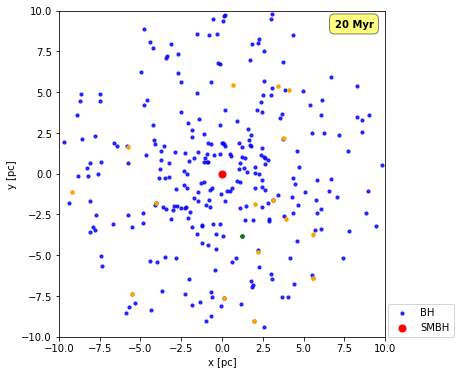



Evolved to t = 21 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BH222' 'BBH256_2'] with hardness = 2.67114466959 d = 8176.21406411 au v = 0.988102673426 kms radius = 9.11887922109 parsec and theta_z = -0.762639759914
Binary 2 is ['BBH226_2' 'BH86'] with hardness = 0.841343831947 d = 3267.11180646 au v = 0.600496371727 kms radius = 9.0952986401 parsec and theta_z = 0.502987535741
Binary 3 is ['BBH61_2' 'BBH61_1'] with hardness = 3.6604897022 d = 917.670706197 au v = 2.13562368462 kms radius = 6.18800009162 parsec and theta_z = -0.825796556009
Binary 4 is ['BBH271_1' 'BBH271_2'] with hardness = 1.29277425381 d = 1205.13720799 au v = 1.38830452535 kms radius = 6.63876961401 parsec and theta_z = 0.999992331893
Binary 5 is ['BBH166_1' 'BBH166_2'] with hardness = 2.2782651519 d = 1415.55371925 au v = 1.04960693373 kms radius = 4.26681738515 parsec and theta_z = 0.999150358274
Binary 6 is ['BBH1_1' 'BH282'] with hardness = 48.0885716728 d = 201.167504609 au v = 4.08537993667 kms radius

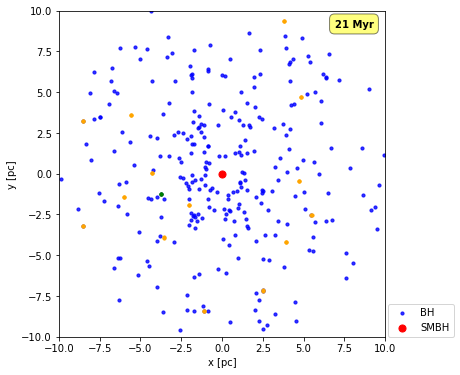



Evolved to t = 22 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BH180' 'BBH106_2'] with hardness = 3.12833403526 d = 541.657462046 au v = 3.4378900723 kms radius = 8.55793781703 parsec and theta_z = 0.220351443762
Binary 2 is ['BBH136_1' 'BBH136_2'] with hardness = 1.51267637747 d = 3142.50534522 au v = 1.0162530226 kms radius = 5.5659233689 parsec and theta_z = 0.99999521566
Binary 3 is ['BBH16_2' 'BBH16_1'] with hardness = 1.20279756445 d = 3205.28651873 au v = 0.694114577408 kms radius = 5.29722240593 parsec and theta_z = 0.4510976896
Binary 4 is ['BH21' 'BBH241_2'] with hardness = 1.72833228984 d = 1731.5722533 au v = 3.12306008703 kms radius = 5.99977454284 parsec and theta_z = -0.635740852072
Binary 5 is ['BH86' 'BBH226_2'] with hardness = 0.837358501813 d = 2117.06561974 au v = 1.06513444517 kms radius = 9.1364192882 parsec and theta_z = 0.525241401927
Binary 6 is ['BBH271_2' 'BBH271_1'] with hardness = 1.28704299771 d = 1428.93483177 au v = 1.17199327467 kms radius = 6.7

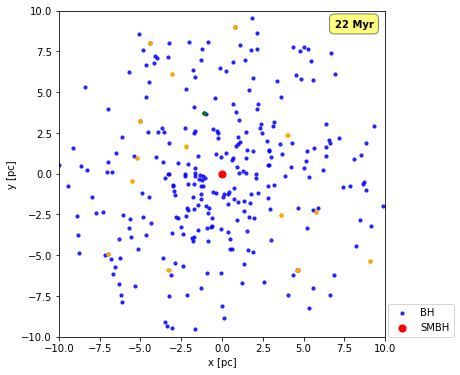



Evolved to t = 23 Myr 
BH number = 280
16 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.13899991926 d = 1380.03886512 au v = 1.49570421703 kms radius = 8.50704025861 parsec and theta_z = 0.214029344275
Binary 2 is ['BBH211_2' 'BBH211_1'] with hardness = 2.69808418141 d = 1847.74323567 au v = 0.680549712122 kms radius = 9.42364345181 parsec and theta_z = 0.994333060301
Binary 3 is ['BBH181_2' 'BBH181_1'] with hardness = 1.58777390559 d = 1449.61247993 au v = 1.61372775646 kms radius = 7.06580004931 parsec and theta_z = 0.99985358473
Binary 4 is ['BH197' 'BH94'] with hardness = 0.635110285457 d = 19662.4337195 au v = 0.357794051642 kms radius = 9.53087482566 parsec and theta_z = 0.909391545868
Binary 5 is ['BBH61_2' 'BBH61_1'] with hardness = 3.66420285346 d = 825.656523511 au v = 2.36224588253 kms radius = 6.24596732982 parsec and theta_z = -0.826025218775
Binary 6 is ['BBH16_2' 'BBH16_1'] with hardness = 1.22760544983 d = 1333.49339921 au v = 1.80649482342 kms radiu

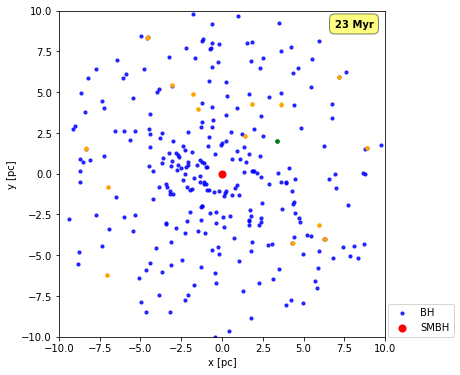



Evolved to t = 24 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.12347946916 d = 1754.37289892 au v = 0.957894562641 kms radius = 8.56832793936 parsec and theta_z = 0.218500908948
Binary 2 is ['BH21' 'BBH241_2'] with hardness = 1.69415126179 d = 6962.90260878 au v = 0.908401672766 kms radius = 5.98688514859 parsec and theta_z = -0.378405097222
Binary 3 is ['BBH181_2' 'BBH181_1'] with hardness = 1.57643542109 d = 1880.13437024 au v = 1.24699511589 kms radius = 7.10837844487 parsec and theta_z = 0.999831329424
Binary 4 is ['BBH211_2' 'BBH211_1'] with hardness = 2.68712739619 d = 1835.0911774 au v = 0.69834981729 kms radius = 9.69799256781 parsec and theta_z = 0.99509560366
Binary 5 is ['BBH286_2' 'BBH286_1'] with hardness = 1.83236566593 d = 1571.22221351 au v = 1.325854734 kms radius = 4.66741226788 parsec and theta_z = 0.999999510434
Binary 6 is ['BBH61_1' 'BBH61_2'] with hardness = 3.64935385039 d = 743.795861444 au v = 2.58829509792 kms radi

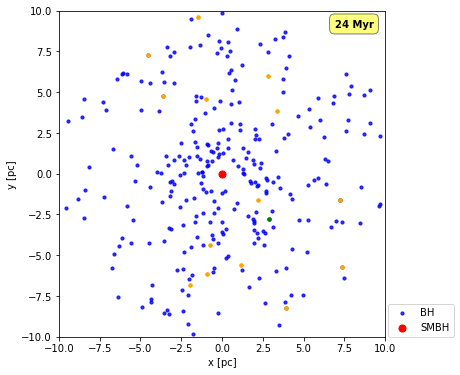



Evolved to t = 25 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BH222' 'BBH256_2'] with hardness = 2.93693689541 d = 6561.28842485 au v = 1.31953846863 kms radius = 9.15889748181 parsec and theta_z = -0.820038991544
Binary 2 is ['BBH271_2' 'BBH271_1'] with hardness = 1.308706555 d = 1198.7738961 au v = 1.39287215418 kms radius = 6.64864634309 parsec and theta_z = 0.999999057505
Binary 3 is ['BBH136_2' 'BBH136_1'] with hardness = 1.56923159985 d = 2762.56517743 au v = 1.17805667814 kms radius = 5.51912747682 parsec and theta_z = 0.999983195528
Binary 4 is ['BH86' 'BBH226_2'] with hardness = 0.844763261231 d = 3386.48978195 au v = 0.56141720558 kms radius = 9.13373525528 parsec and theta_z = 0.656033169788
Binary 5 is ['BBH1_1' 'BH282'] with hardness = 50.2406347615 d = 99.1607135126 au v = 9.69508677328 kms radius = 3.9477448332 parsec and theta_z = -0.348449250133
Here we have a hard binary!!!
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.25699885794 d = 1975.75184293 au

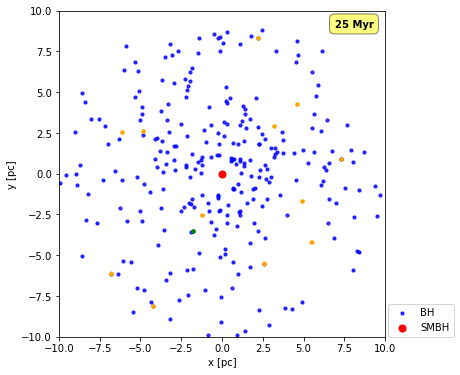



Evolved to t = 26 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.846871629146 d = 1043.20429123 au v = 1.84136033777 kms radius = 9.08315305918 parsec and theta_z = 0.503533782051
Binary 2 is ['BH222' 'BBH256_2'] with hardness = 2.93780593366 d = 6451.36700917 au v = 1.35363372007 kms radius = 9.10720840087 parsec and theta_z = -0.800653625203
Binary 3 is ['BBH61_1' 'BBH61_2'] with hardness = 3.70265625389 d = 1049.39872599 au v = 1.84278729526 kms radius = 6.22759634818 parsec and theta_z = -0.822592408516
Binary 4 is ['BBH166_1' 'BBH166_2'] with hardness = 2.29938868081 d = 641.00098437 au v = 2.42866588879 kms radius = 4.30178023606 parsec and theta_z = 0.999215783507
Binary 5 is ['BBH1_1' 'BH282'] with hardness = 50.7160267032 d = 165.306422216 au v = 5.53910909529 kms radius = 3.89385313808 parsec and theta_z = -0.348105046367
Here we have a hard binary!!!
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.37038314791 d = 1668.31385275 

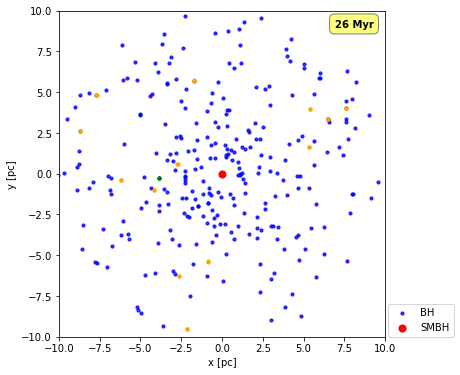



Evolved to t = 27 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 2.72520653263 d = 1818.74710502 au v = 0.720594188124 kms radius = 9.29083181309 parsec and theta_z = 0.996663463224
Binary 2 is ['BBH16_1' 'BBH16_2'] with hardness = 1.53531202029 d = 1427.45627484 au v = 1.60486679165 kms radius = 5.36623478876 parsec and theta_z = 0.0280887201013
Binary 3 is ['BBH181_2' 'BBH181_1'] with hardness = 1.60455921578 d = 2132.91148729 au v = 1.06074085794 kms radius = 6.77740032618 parsec and theta_z = 0.999867511939
Binary 4 is ['BBH1_1' 'BH282'] with hardness = 51.2199570348 d = 141.162221548 au v = 6.79375126943 kms radius = 3.83612773736 parsec and theta_z = -0.350564463662
Here we have a hard binary!!!
Binary 5 is ['BBH136_2' 'BBH136_1'] with hardness = 1.55988532525 d = 1993.19714824 au v = 1.64085208117 kms radius = 5.70123481397 parsec and theta_z = 0.999970866181
Binary 6 is ['BH21' 'BBH241_2'] with hardness = 1.7250385026 d = 7074.9094211

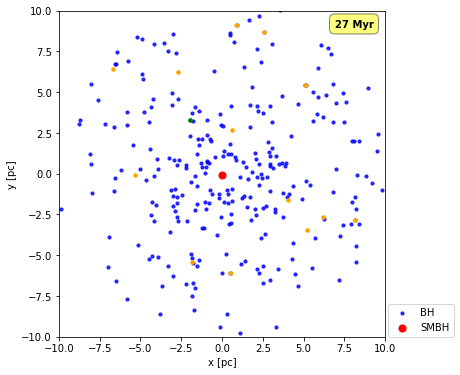



Evolved to t = 28 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH181_2' 'BBH181_1'] with hardness = 1.5901179671 d = 2020.46089608 au v = 1.13722358506 kms radius = 7.04122387339 parsec and theta_z = 0.999869461915
Binary 2 is ['BBH166_1' 'BBH166_2'] with hardness = 2.37364121227 d = 570.546000192 au v = 2.61796852384 kms radius = 4.25817189002 parsec and theta_z = 0.993035904221
Binary 3 is ['BBH136_1' 'BBH136_2'] with hardness = 1.534266768 d = 1760.86608654 au v = 1.82027225695 kms radius = 5.49926295194 parsec and theta_z = 0.999954792439
Binary 4 is ['BBH61_1' 'BBH61_2'] with hardness = 3.66335573711 d = 787.776293252 au v = 2.46061694589 kms radius = 6.25206462438 parsec and theta_z = -0.815190076177
Binary 5 is ['BBH16_1' 'BBH16_2'] with hardness = 1.51528771557 d = 3304.10365732 au v = 0.161302887863 kms radius = 5.23048968796 parsec and theta_z = -0.304540812909
Binary 6 is ['BH21' 'BBH241_2'] with hardness = 1.67380895995 d = 8049.90984553 au v = 0.672536485829 kms r

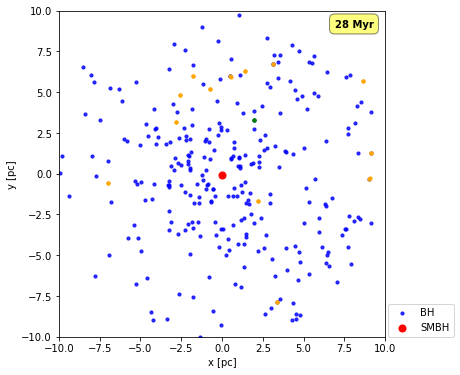



Evolved to t = 29 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH271_1' 'BBH271_2'] with hardness = 1.323832634 d = 1421.25964711 au v = 1.16836057416 kms radius = 6.60558273782 parsec and theta_z = 0.99989191981
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.17698544401 d = 1904.96307488 au v = 0.723982117884 kms radius = 8.57912483731 parsec and theta_z = 0.365311236588
Binary 3 is ['BBH196_1' 'BBH196_2'] with hardness = 6.73569478412 d = 1348.83425562 au v = 3.23065562847 kms radius = 2.85009800315 parsec and theta_z = 0.0550467358864
Binary 4 is ['BBH61_2' 'BBH61_1'] with hardness = 3.71481034221 d = 1035.79120549 au v = 1.86966859033 kms radius = 6.23313215399 parsec and theta_z = -0.814196269962
Binary 5 is ['BBH181_2' 'BBH181_1'] with hardness = 1.61146350569 d = 1265.31954011 au v = 1.80700124813 kms radius = 7.11556573731 parsec and theta_z = 0.999831992679
Binary 6 is ['BH21' 'BBH241_2'] with hardness = 1.66961842009 d = 4264.78523645 au v = 1.66290116452 kms rad

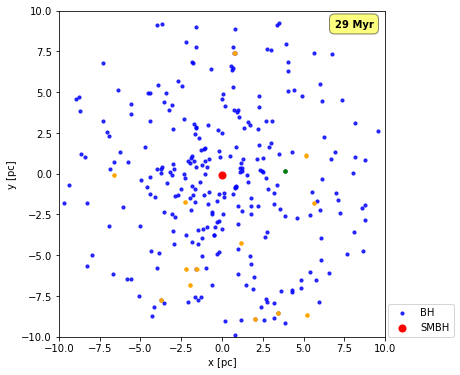



Evolved to t = 30 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BBH211_1' 'BBH211_2'] with hardness = 2.6858444943 d = 1383.97263715 au v = 1.3222167252 kms radius = 9.11369918544 parsec and theta_z = 0.997778491703
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.12386088829 d = 2029.87183751 au v = 0.49689213054 kms radius = 8.54927450329 parsec and theta_z = 0.403105955751
Binary 3 is ['BH171' 'BBH256_2'] with hardness = 1.83729593585 d = 8341.92112234 au v = 1.26715158862 kms radius = 9.15136556016 parsec and theta_z = 0.498159410405
Binary 4 is ['BBH256_2' 'BH224'] with hardness = 0.864746044797 d = 17471.8001774 au v = 0.594229093416 kms radius = 9.14175531755 parsec and theta_z = -0.975750375736
Binary 5 is ['BBH226_2' 'BH86'] with hardness = 0.833736520855 d = 2273.18177226 au v = 0.992082042246 kms radius = 9.02629998059 parsec and theta_z = 0.474786024233
Binary 6 is ['BBH136_2' 'BBH136_1'] with hardness = 1.43151590649 d = 2713.85463464 au v = 1.26202041047 kms radi

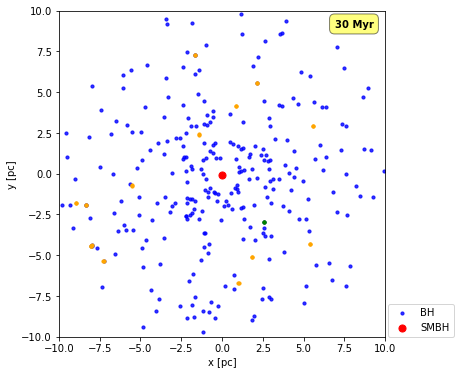



Evolved to t = 31 Myr 
BH number = 280
17 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.840355674062 d = 3577.98322287 au v = 0.492579373973 kms radius = 8.95978426393 parsec and theta_z = 0.500570732825
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.15899325382 d = 2061.90178935 au v = 0.423442305938 kms radius = 8.64645059504 parsec and theta_z = 0.451480212177
Binary 3 is ['BBH256_2' 'BH222'] with hardness = 1.27120487824 d = 16860.8670922 au v = 0.714253778228 kms radius = 9.24255291949 parsec and theta_z = 0.368964713903
Binary 4 is ['BH222' 'BH224'] with hardness = 0.921916679517 d = 11301.476761 au v = 0.306699810057 kms radius = 9.22103887094 parsec and theta_z = -0.443764767397
Binary 5 is ['BBH61_2' 'BBH61_1'] with hardness = 3.69889890181 d = 852.161805192 au v = 2.2882464942 kms radius = 6.22793437645 parsec and theta_z = -0.812722521002
Binary 6 is ['BH35' 'BH258'] with hardness = 0.743203929768 d = 4177.22831355 au v = 1.49755462429 kms radius = 5.1

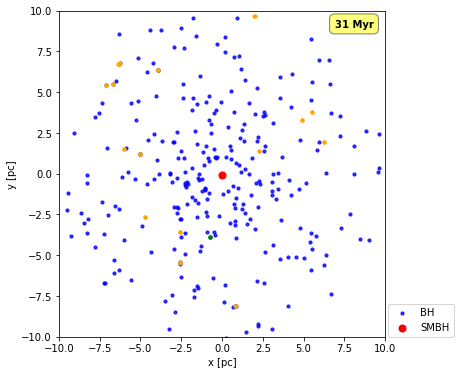



Evolved to t = 32 Myr 
BH number = 280
16 Binary found
Binary 1 is ['BH152' 'BH253'] with hardness = 2.77435795894 d = 3771.50589365 au v = 0.772356053465 kms radius = 7.53376207457 parsec and theta_z = 0.452894167107
Binary 2 is ['BBH1_1' 'BH282'] with hardness = 53.6797652183 d = 66.8935256412 au v = 12.8666094803 kms radius = 3.91914768881 parsec and theta_z = -0.360208389382
Here we have a hard binary!!!
Binary 3 is ['BBH271_1' 'BBH271_2'] with hardness = 1.3277107036 d = 1154.00055839 au v = 1.43562639481 kms radius = 6.44704570292 parsec and theta_z = 0.999857710126
Binary 4 is ['BBH16_1' 'BBH16_2'] with hardness = 1.56691915511 d = 1241.77952392 au v = 1.79283802785 kms radius = 5.2771682715 parsec and theta_z = 0.0443270189381
Binary 5 is ['BBH136_1' 'BBH136_2'] with hardness = 1.47875752489 d = 2477.8309795 au v = 1.37556538104 kms radius = 5.69166950747 parsec and theta_z = 0.999813354049
Binary 6 is ['BBH181_2' 'BBH181_1'] with hardness = 1.60676884647 d = 2213.58193642 au

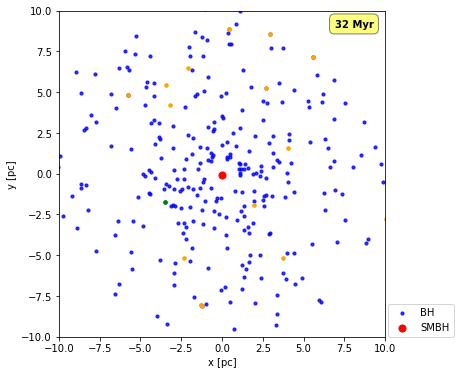



Evolved to t = 33 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH181_1' 'BBH181_2'] with hardness = 1.58402254094 d = 2006.97875371 au v = 1.15287702129 kms radius = 7.07699177284 parsec and theta_z = 0.999882664532
Binary 2 is ['BH152' 'BH253'] with hardness = 2.74366921314 d = 4008.98745778 au v = 0.59371956088 kms radius = 7.56406216524 parsec and theta_z = 0.411914427578
Binary 3 is ['BBH271_1' 'BBH271_2'] with hardness = 1.3125792714 d = 1437.63187762 au v = 1.15194499948 kms radius = 6.70578340316 parsec and theta_z = 0.999850774353
Binary 4 is ['BBH166_2' 'BBH166_1'] with hardness = 2.38628898283 d = 440.447870641 au v = 3.12365248325 kms radius = 4.29231582137 parsec and theta_z = 0.99062557307
Binary 5 is ['BBH211_2' 'BBH211_1'] with hardness = 2.70414297253 d = 1399.30679005 au v = 1.30015957586 kms radius = 9.48685964229 parsec and theta_z = 0.998025033104
Binary 6 is ['BBH1_1' 'BH282'] with hardness = 53.359291908 d = 160.460985351 au v = 5.44379389436 kms radius =

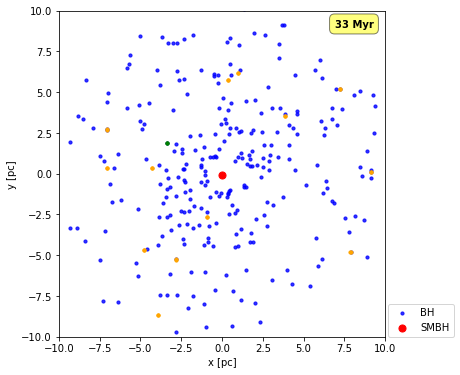



Evolved to t = 34 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BH152' 'BH253'] with hardness = 2.75327498302 d = 928.867353269 au v = 3.60450156172 kms radius = 7.59855106678 parsec and theta_z = 0.328825251419
Binary 2 is ['BBH211_2' 'BBH211_1'] with hardness = 2.72108175956 d = 1771.50452973 au v = 0.786117630628 kms radius = 9.29772742511 parsec and theta_z = 0.997787232212
Binary 3 is ['BBH61_1' 'BBH61_2'] with hardness = 3.72246895927 d = 801.092551889 au v = 2.4173475592 kms radius = 6.30833515796 parsec and theta_z = -0.792371977186
Binary 4 is ['BBH256_2' 'BH222'] with hardness = 2.14413822385 d = 9542.78391399 au v = 1.01662653212 kms radius = 9.39702908738 parsec and theta_z = -0.578004174306
Binary 5 is ['BBH181_2' 'BBH181_1'] with hardness = 1.59510121912 d = 1633.41954791 au v = 1.44472627415 kms radius = 7.16877402548 parsec and theta_z = 0.999869753006
Binary 6 is ['BBH196_1' 'BBH196_2'] with hardness = 6.75461864254 d = 2449.9614958 au v = 1.38103336193 kms radi

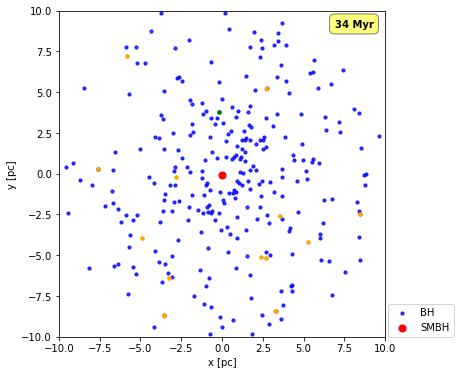



Evolved to t = 35 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH256_2' 'BH222'] with hardness = 2.10127721844 d = 6423.75285391 au v = 1.70224699389 kms radius = 9.34036986661 parsec and theta_z = -0.736753465849
Binary 2 is ['BH253' 'BH152'] with hardness = 2.76823986332 d = 3677.14201811 au v = 0.831574522532 kms radius = 7.6269797836 parsec and theta_z = 0.306205791475
Binary 3 is ['BBH226_2' 'BH86'] with hardness = 0.84520634176 d = 3489.01430794 au v = 0.522610364516 kms radius = 8.90463458462 parsec and theta_z = 0.580509078251
Binary 4 is ['BBH16_1' 'BBH16_2'] with hardness = 1.58332264567 d = 1837.89139965 au v = 1.22856379967 kms radius = 5.58629161617 parsec and theta_z = -0.000551213660829
Binary 5 is ['BBH136_1' 'BBH136_2'] with hardness = 1.48717486885 d = 2350.95169915 au v = 1.4402282149 kms radius = 5.6493481064 parsec and theta_z = 0.999817535406
Binary 6 is ['BH21' 'BBH241_2'] with hardness = 1.88378781902 d = 2532.25681276 au v = 2.40963404296 kms radius = 

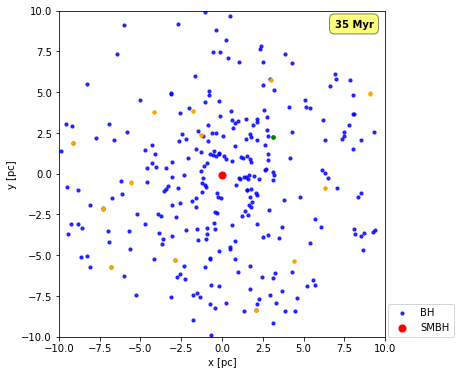



Evolved to t = 36 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BH86' 'BBH226_2'] with hardness = 0.831641987653 d = 1278.37969726 au v = 1.60412281897 kms radius = 8.93783558187 parsec and theta_z = 0.454169354869
Binary 2 is ['BBH271_2' 'BBH271_1'] with hardness = 1.30802154375 d = 1397.89080672 au v = 1.18462966494 kms radius = 6.54464295306 parsec and theta_z = 0.999956868328
Binary 3 is ['BBH106_2' 'BH180'] with hardness = 3.14325408676 d = 2053.51039214 au v = 0.406623220553 kms radius = 8.5799068664 parsec and theta_z = 0.612272910823
Binary 4 is ['BH152' 'BH253'] with hardness = 2.72535600544 d = 3447.72534874 au v = 0.983009395955 kms radius = 7.63499815487 parsec and theta_z = 0.336946598707
Binary 5 is ['BBH61_1' 'BBH61_2'] with hardness = 3.68235363297 d = 797.856084604 au v = 2.42276086619 kms radius = 6.28387212231 parsec and theta_z = -0.786670720579
Binary 6 is ['BBH166_2' 'BBH166_1'] with hardness = 2.36752448441 d = 712.775676291 au v = 2.20877316061 kms radius

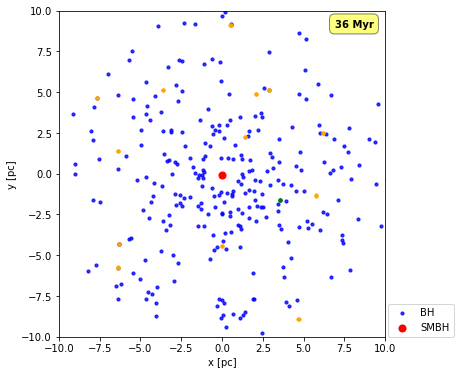



Evolved to t = 37 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 2.68041845314 d = 799.722300863 au v = 2.34737370115 kms radius = 9.07361587008 parsec and theta_z = 0.997083771652
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.14289756795 d = 1585.2548256 au v = 1.17937350991 kms radius = 8.72992810907 parsec and theta_z = 0.46661070335
Binary 3 is ['BBH136_1' 'BBH136_2'] with hardness = 1.44922311784 d = 2240.49802388 au v = 1.5115133009 kms radius = 5.62978409923 parsec and theta_z = 0.999709019679
Binary 4 is ['BH253' 'BH152'] with hardness = 2.71804409736 d = 2450.79340046 au v = 1.66564468543 kms radius = 7.63970325714 parsec and theta_z = 0.428858189712
Binary 5 is ['BBH241_2' 'BH21'] with hardness = 1.84430768939 d = 4538.76240524 au v = 1.48593740926 kms radius = 6.03655088723 parsec and theta_z = -0.123280378707
Binary 6 is ['BBH61_2' 'BBH61_1'] with hardness = 3.68516369685 d = 880.578237567 au v = 2.20704762406 kms radius = 6.

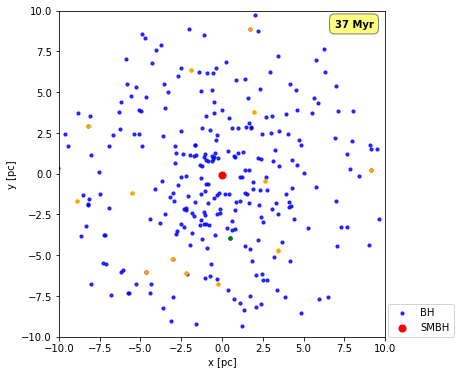



Evolved to t = 38 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH181_2' 'BBH181_1'] with hardness = 1.55154429971 d = 1561.92290377 au v = 1.5229856568 kms radius = 6.93943146659 parsec and theta_z = 0.999377025319
Binary 2 is ['BBH16_1' 'BBH16_2'] with hardness = 1.53767471228 d = 2980.74356963 au v = 0.464849148981 kms radius = 5.59632522632 parsec and theta_z = 0.021824497826
Binary 3 is ['BBH166_1' 'BBH166_2'] with hardness = 2.39126422968 d = 583.878171746 au v = 2.57267021868 kms radius = 4.36264568173 parsec and theta_z = 0.994075673095
Binary 4 is ['BBH1_1' 'BH282'] with hardness = 54.8444721416 d = 179.92106503 au v = 4.16639061399 kms radius = 3.94687070485 parsec and theta_z = -0.388532269921
Here we have a hard binary!!!
Binary 5 is ['BH253' 'BH152'] with hardness = 2.75350237343 d = 4179.47655736 au v = 0.433975186371 kms radius = 7.63539147908 parsec and theta_z = 0.444913200437
Binary 6 is ['BH180' 'BBH106_2'] with hardness = 3.17716184168 d = 575.843952019 au v

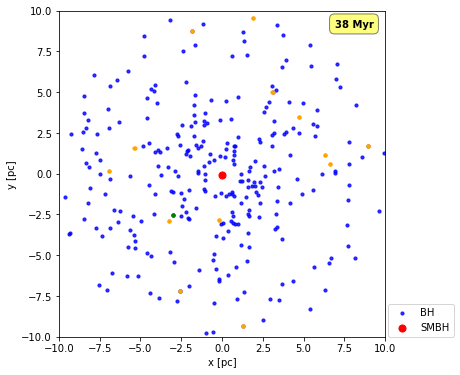



Evolved to t = 39 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH256_2' 'BH222'] with hardness = 1.9644724367 d = 7812.97470382 au v = 1.42669257352 kms radius = 9.47876603329 parsec and theta_z = -0.544574230012
Binary 2 is ['BBH61_1' 'BBH61_2'] with hardness = 3.68294434511 d = 775.235004958 au v = 2.48115776959 kms radius = 6.40911225119 parsec and theta_z = -0.788404511767
Binary 3 is ['BBH1_1' 'BH282'] with hardness = 54.4127885374 d = 68.1576219204 au v = 12.5934554066 kms radius = 3.87960980667 parsec and theta_z = -0.39557772341
Here we have a hard binary!!!
Binary 4 is ['BBH241_2' 'BH21'] with hardness = 1.85641189476 d = 4468.65056571 au v = 1.50190633607 kms radius = 6.02679164891 parsec and theta_z = -0.197829174545
Binary 5 is ['BBH181_1' 'BBH181_2'] with hardness = 1.53747950997 d = 1774.36254238 au v = 1.3410555357 kms radius = 7.09191323916 parsec and theta_z = 0.999346954956
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.60686286612 d = 1707.78410611 au

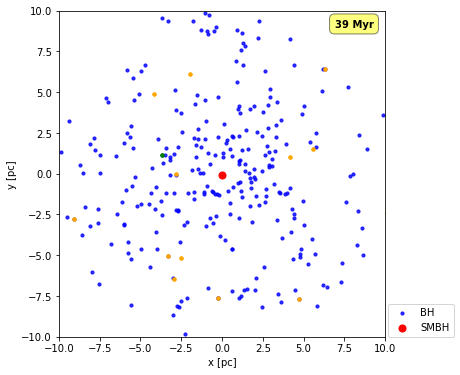



Evolved to t = 40 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BBH271_2' 'BBH271_1'] with hardness = 1.33413413765 d = 1253.26314104 au v = 1.32113229966 kms radius = 6.671341497 parsec and theta_z = 0.999917467992
Binary 2 is ['BBH226_2' 'BH86'] with hardness = 0.843586868103 d = 2411.52173267 au v = 0.930543150238 kms radius = 8.94332901327 parsec and theta_z = 0.528683840912
Binary 3 is ['BBH166_2' 'BBH166_1'] with hardness = 2.39815251807 d = 1328.25743694 au v = 1.10617201196 kms radius = 4.28211500883 parsec and theta_z = 0.992753783932
Binary 4 is ['BBH16_1' 'BBH16_2'] with hardness = 1.55662438823 d = 1026.10375792 au v = 2.07286733641 kms radius = 5.74828947961 parsec and theta_z = 0.0700224051935
Binary 5 is ['BBH256_2' 'BH222'] with hardness = 2.01021962457 d = 11436.0078653 au v = 0.76255606718 kms radius = 9.21692094448 parsec and theta_z = -0.582161164452
Binary 6 is ['BBH211_1' 'BBH211_2'] with hardness = 2.72135575288 d = 524.501888 au v = 3.1914165975 kms radiu

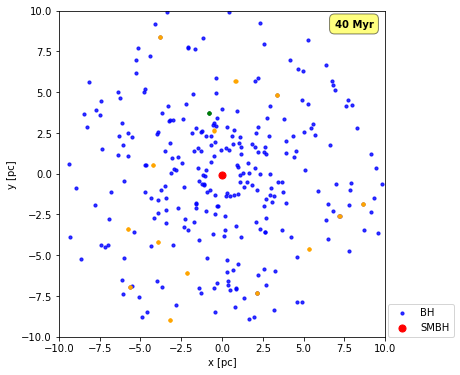



Evolved to t = 41 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.836901620692 d = 3936.31232281 au v = 0.35038253609 kms radius = 8.97004897614 parsec and theta_z = 0.663400835628
Binary 2 is ['BBH211_2' 'BBH211_1'] with hardness = 2.70573175018 d = 1574.70964073 au v = 1.05601891748 kms radius = 9.18359171105 parsec and theta_z = 0.994184534082
Binary 3 is ['BH21' 'BBH241_2'] with hardness = 1.84979198732 d = 4764.87405535 au v = 1.41536811758 kms radius = 6.033144816 parsec and theta_z = -0.299758680004
Binary 4 is ['BBH16_1' 'BBH16_2'] with hardness = 1.54653027593 d = 2910.25692192 au v = 0.501904592188 kms radius = 5.69456512023 parsec and theta_z = 0.219057111462
Binary 5 is ['BBH136_1' 'BBH136_2'] with hardness = 1.47900220516 d = 2647.48567286 au v = 1.27549374168 kms radius = 5.85315439329 parsec and theta_z = 0.999564963611
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.52532688993 d = 2824.4128474 au v = 0.871218850742 kms rad

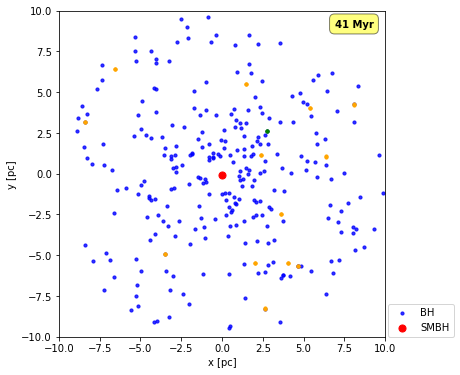



Evolved to t = 42 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.16600894361 d = 1591.39682174 au v = 1.16751911578 kms radius = 8.59645856025 parsec and theta_z = 0.307157458247
Binary 2 is ['BBH61_2' 'BBH61_1'] with hardness = 3.72608081588 d = 994.460546333 au v = 1.93669430588 kms radius = 6.42802317272 parsec and theta_z = -0.795249852207
Binary 3 is ['BBH136_1' 'BBH136_2'] with hardness = 1.47307561165 d = 2132.81305579 au v = 1.57262802977 kms radius = 5.67572745527 parsec and theta_z = 0.999543863822
Binary 4 is ['BBH181_1' 'BBH181_2'] with hardness = 2.92375671574 d = 1227.01344743 au v = 1.31926699578 kms radius = 6.63285465969 parsec and theta_z = 0.909779611324
Binary 5 is ['BBH166_1' 'BBH166_2'] with hardness = 2.37749536581 d = 996.611192988 au v = 1.62291520725 kms radius = 4.2183380261 parsec and theta_z = 0.98889722036
Binary 6 is ['BBH226_2' 'BH86'] with hardness = 0.833396726742 d = 3648.50510864 au v = 0.466711843498 kms ra

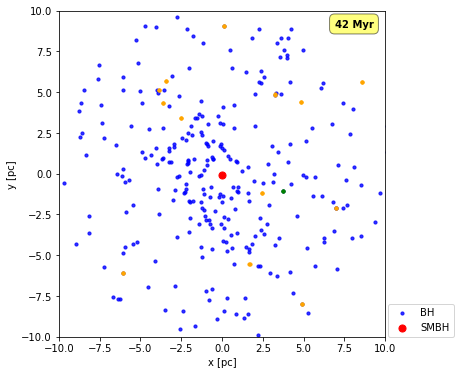



Evolved to t = 43 Myr 
BH number = 280
15 Binary found
Binary 1 is ['BBH106_2' 'BH180'] with hardness = 3.1957215388 d = 1592.79835817 au v = 1.16580477438 kms radius = 8.73217505011 parsec and theta_z = 0.265217015301
Binary 2 is ['BH222' 'BBH256_2'] with hardness = 1.99838774052 d = 4400.71046531 au v = 2.35831821509 kms radius = 9.51945282894 parsec and theta_z = -0.559047678214
Binary 3 is ['BBH181_2' 'BBH181_1'] with hardness = 2.95098393196 d = 785.564607106 au v = 2.19032610734 kms radius = 6.92774757512 parsec and theta_z = 0.919124363236
Binary 4 is ['BBH271_1' 'BBH271_2'] with hardness = 1.33310558706 d = 1439.99833954 au v = 1.14268457095 kms radius = 6.46077785007 parsec and theta_z = 0.999803268878
Binary 5 is ['BBH16_1' 'BBH16_2'] with hardness = 1.57392841363 d = 2650.96850224 au v = 0.668771710984 kms radius = 5.64248563347 parsec and theta_z = 0.0742736295344
Binary 6 is ['BBH241_2' 'BH21'] with hardness = 1.74824725435 d = 6286.70086708 au v = 1.04756283139 kms radi

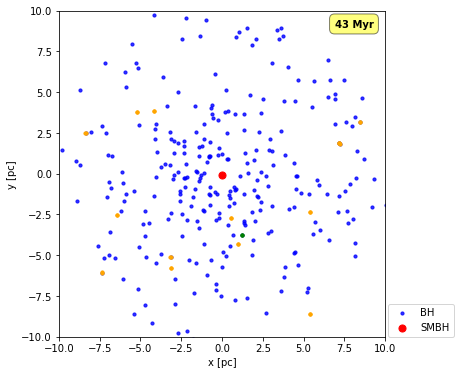



Evolved to t = 44 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH211_2' 'BBH211_1'] with hardness = 2.71932198292 d = 315.583285519 au v = 4.38029031489 kms radius = 9.12474647988 parsec and theta_z = 0.99253414367
Binary 2 is ['BBH256_2' 'BH222'] with hardness = 1.99391705887 d = 9499.85428031 au v = 1.10984948166 kms radius = 9.35948207599 parsec and theta_z = -0.475104023114
Binary 3 is ['BBH136_2' 'BBH136_1'] with hardness = 1.48903247816 d = 2103.89702961 au v = 1.58923088605 kms radius = 5.73570092879 parsec and theta_z = 0.99959006858
Binary 4 is ['BBH106_2' 'BH180'] with hardness = 3.18901117484 d = 1594.57583447 au v = 1.16246270641 kms radius = 8.86650006078 parsec and theta_z = 0.270063911533
Binary 5 is ['BBH271_1' 'BBH271_2'] with hardness = 1.33303590176 d = 1179.03967174 au v = 1.40007103441 kms radius = 6.81038031268 parsec and theta_z = 0.999783540497
Binary 6 is ['BH282' 'BBH1_1'] with hardness = 58.1378924441 d = 104.266984951 au v = 8.72051590854 kms radius

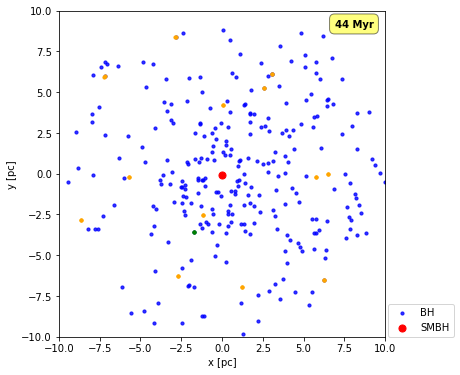



Evolved to t = 45 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH16_1' 'BBH16_2'] with hardness = 1.59734050393 d = 1847.58094768 au v = 1.21418120838 kms radius = 5.69138765361 parsec and theta_z = 0.294933576428
Binary 2 is ['BBH226_2' 'BH86'] with hardness = 0.849122777961 d = 2810.01383364 au v = 0.768101186596 kms radius = 8.97072939684 parsec and theta_z = 0.470960360432
Binary 3 is ['BBH1_1' 'BH282'] with hardness = 58.8567475048 d = 49.7624859851 au v = 15.4521905173 kms radius = 3.92407847332 parsec and theta_z = -0.440059893263
Here we have a hard binary!!!
Binary 4 is ['BH253' 'BH218'] with hardness = 4.24720085258 d = 1909.41240261 au v = 1.6968867415 kms radius = 7.14986889552 parsec and theta_z = -0.327824492495
Binary 5 is ['BBH61_1' 'BBH61_2'] with hardness = 3.77275162901 d = 853.862949536 au v = 2.26737852276 kms radius = 6.41132480005 parsec and theta_z = -0.806442657307
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.83604508508 d = 2527.09820378 au v

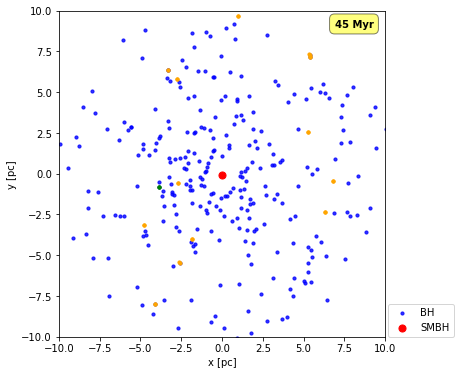



Evolved to t = 46 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.841345939057 d = 2951.61994279 au v = 0.714749372758 kms radius = 8.93503767562 parsec and theta_z = 0.435817947098
Binary 2 is ['BH218' 'BH253'] with hardness = 4.21142644561 d = 784.796776403 au v = 3.82235539145 kms radius = 7.45315905833 parsec and theta_z = -0.340554436192
Binary 3 is ['BBH61_1' 'BBH61_2'] with hardness = 3.74043267708 d = 703.511938679 au v = 2.69171267137 kms radius = 6.55491549011 parsec and theta_z = -0.805246433405
Binary 4 is ['BBH136_2' 'BBH136_1'] with hardness = 1.46083012576 d = 2695.85768251 au v = 1.26010004149 kms radius = 5.69311024417 parsec and theta_z = 0.999519388692
Binary 5 is ['BBH1_1' 'BH282'] with hardness = 58.7596050494 d = 172.864032451 au v = 3.97383553553 kms radius = 3.80335955297 parsec and theta_z = -0.451179219729
Here we have a hard binary!!!
Binary 6 is ['BBH196_2' 'BBH196_1'] with hardness = 6.88275875876 d = 1798.76676564 a

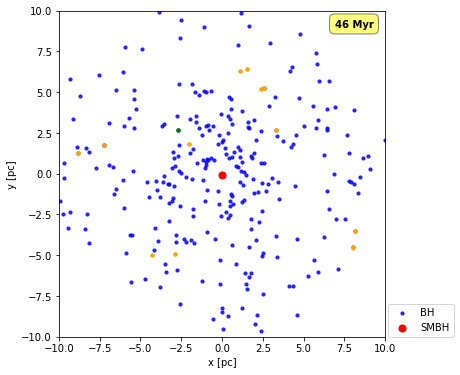



Evolved to t = 47 Myr 
BH number = 280
14 Binary found
Binary 1 is ['BBH271_1' 'BBH271_2'] with hardness = 1.33221839123 d = 1258.56665335 au v = 1.31155525206 kms radius = 6.52657704045 parsec and theta_z = 0.999694594021
Binary 2 is ['BH253' 'BH218'] with hardness = 4.20478260679 d = 2379.02565261 au v = 1.12027269315 kms radius = 7.49582766163 parsec and theta_z = -0.370308538623
Binary 3 is ['BBH181_2' 'BBH181_1'] with hardness = 2.92817615227 d = 670.84724674 au v = 2.49885876262 kms radius = 6.76501530399 parsec and theta_z = 0.945511341212
Binary 4 is ['BBH166_1' 'BBH166_2'] with hardness = 2.35866463325 d = 1420.18780945 au v = 0.98782743773 kms radius = 4.32625643383 parsec and theta_z = 0.986934534301
Binary 5 is ['BBH256_2' 'BH222'] with hardness = 2.4752955774 d = 9129.16916852 au v = 0.870454447597 kms radius = 9.37988757905 parsec and theta_z = -0.684914688976
Binary 6 is ['BBH211_2' 'BBH211_1'] with hardness = 2.7021467056 d = 1699.3406261 au v = 0.88343033135 kms radi

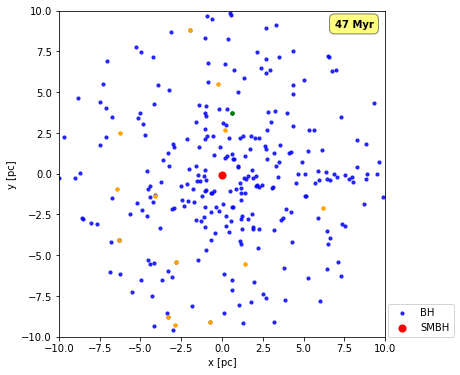



Evolved to t = 48 Myr 
BH number = 280
13 Binary found
Binary 1 is ['BBH256_2' 'BH222'] with hardness = 2.36105468831 d = 9830.00836491 au v = 0.799927916628 kms radius = 9.27241527549 parsec and theta_z = -0.693917235469
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.23301337028 d = 886.634258143 au v = 2.35923667737 kms radius = 9.22853710175 parsec and theta_z = 0.418819990888
Binary 3 is ['BBH211_1' 'BBH211_2'] with hardness = 2.71665309828 d = 1268.04653553 au v = 1.48557644042 kms radius = 9.07568393401 parsec and theta_z = 0.991013887479
Binary 4 is ['BBH16_1' 'BBH16_2'] with hardness = 1.59245386401 d = 999.603647945 au v = 2.10042475389 kms radius = 5.65807363095 parsec and theta_z = 0.0835457812196
Binary 5 is ['BBH181_2' 'BBH181_1'] with hardness = 2.94459805695 d = 1337.20844798 au v = 1.13368364746 kms radius = 7.06557894015 parsec and theta_z = 0.94429637726
Binary 6 is ['BH253' 'BH218'] with hardness = 4.22515110654 d = 2302.8925254 au v = 1.21376465058 kms radius 

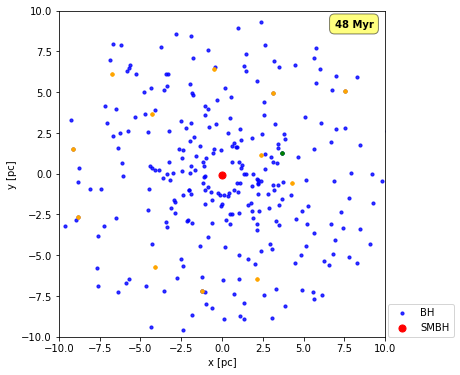



Evolved to t = 49 Myr 
BH number = 280
13 Binary found
Binary 1 is ['BBH61_2' 'BBH61_1'] with hardness = 3.75010654198 d = 1127.00590479 au v = 1.65711391582 kms radius = 6.53081778579 parsec and theta_z = -0.812286205751
Binary 2 is ['BBH106_2' 'BH180'] with hardness = 3.23066533544 d = 1467.73192806 au v = 1.32350448499 kms radius = 8.6364257021 parsec and theta_z = 0.420516282527
Binary 3 is ['BBH166_2' 'BBH166_1'] with hardness = 2.38129730197 d = 519.542383922 au v = 2.79680853666 kms radius = 4.23835834681 parsec and theta_z = 0.988218937339
Binary 4 is ['BH21' 'BBH241_2'] with hardness = 2.34305890027 d = 4999.85258353 au v = 1.08784266569 kms radius = 6.10695809111 parsec and theta_z = -0.503394308311
Binary 5 is ['BH222' 'BBH256_2'] with hardness = 2.33197158386 d = 3013.61079589 au v = 2.9734038655 kms radius = 9.11339287171 parsec and theta_z = -0.638797690791
Binary 6 is ['BH58' 'BBH196_1'] with hardness = 11.0998604757 d = 4827.55894192 au v = 3.60676051097 kms radius = 

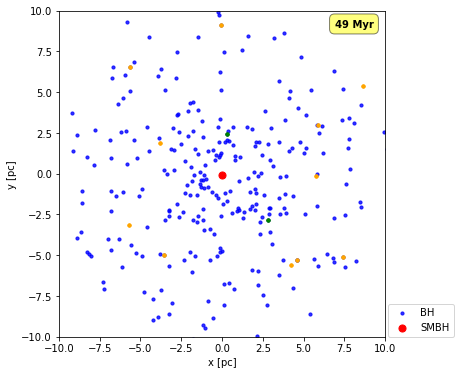



Evolved to t = 50 Myr 
BH number = 280
12 Binary found
Binary 1 is ['BBH16_2' 'BBH16_1'] with hardness = 1.59071097579 d = 889.958021088 au v = 2.28110048476 kms radius = 6.24645162218 parsec and theta_z = 0.0110310365188
Binary 2 is ['BBH271_1' 'BBH271_2'] with hardness = 1.33643950058 d = 1175.50392205 au v = 1.40109371601 kms radius = 6.42118071309 parsec and theta_z = 0.999698813176
Binary 3 is ['BBH226_2' 'BH86'] with hardness = 0.537418530677 d = 5491.84759955 au v = 0.410432308238 kms radius = 8.9395794496 parsec and theta_z = 0.118671156435
Binary 4 is ['BH282' 'BBH1_1'] with hardness = 67.3586647675 d = 159.541457967 au v = 3.55365837278 kms radius = 4.02118324238 parsec and theta_z = -0.389447270623
Here we have a hard binary!!!
Binary 5 is ['BBH166_2' 'BBH166_1'] with hardness = 2.37735613179 d = 1034.22164612 au v = 1.5630194163 kms radius = 4.39698210179 parsec and theta_z = 0.987317623067
Binary 6 is ['BBH106_2' 'BH180'] with hardness = 3.23136498557 d = 791.008183858 a

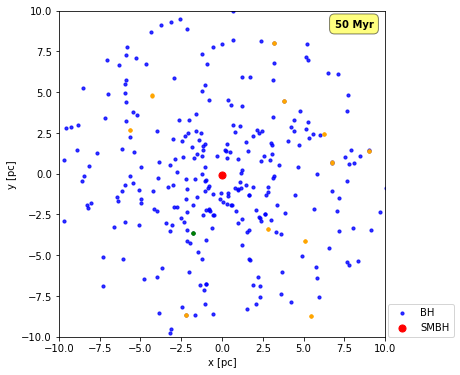



Evolved to t = 51 Myr 
BH number = 280
12 Binary found
Binary 1 is ['BBH226_2' 'BH86'] with hardness = 0.537447262424 d = 4857.26237252 au v = 0.531943270047 kms radius = 8.92354642042 parsec and theta_z = 0.198476320566
Binary 2 is ['BBH211_1' 'BBH211_2'] with hardness = 2.73533729306 d = 1763.65563204 au v = 0.788768280747 kms radius = 9.15614198433 parsec and theta_z = 0.991876177368
Binary 3 is ['BH21' 'BBH241_2'] with hardness = 2.36472587926 d = 4263.11616532 au v = 1.37461892772 kms radius = 6.10932220792 parsec and theta_z = -0.680791904646
Binary 4 is ['BBH271_1' 'BBH271_2'] with hardness = 1.34537976403 d = 1427.24059636 au v = 1.14857136565 kms radius = 6.71416164382 parsec and theta_z = 0.999683527212
Binary 5 is ['BH282' 'BBH1_1'] with hardness = 69.0519505707 d = 147.197611971 au v = 4.38177751935 kms radius = 3.88725284882 parsec and theta_z = -0.387126152639
Here we have a hard binary!!!
Binary 6 is ['BBH166_2' 'BBH166_1'] with hardness = 2.39458887104 d = 1330.122322

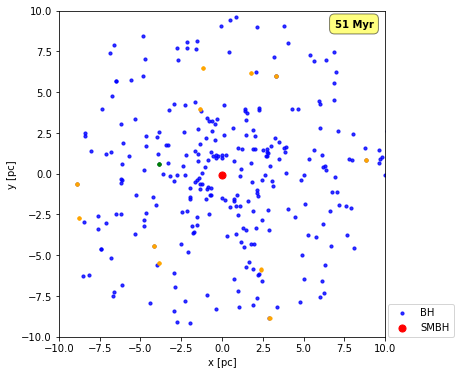

Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/run_command_redirected.py", line 37, in <module>
    returncode = call(
                 ^^^^^
  File "/usr/lib64/python3.11/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/subprocess.py", line 1262, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/subprocess.py", line 1997, in _wait
    (pid, sts) = self._try_wait(0)
                 ^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/subprocess.py", line 1955, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [49]:
# Stopping condition of collision 
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies.radius *= collision_radius_multiplication_factor

# Evolving parameters
end_time = 80 | units.Myr
model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

evolve_time_list = [] | units.Myr 
average_Ek_list = [] | units.kms**2

binary_n = []

bodies_x = []
bodies_y = []

# Evolve
while(model_time<end_time):
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
    channel.copy()
    
    bodies_x.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    bodies_y.append(bodies.y.value_in(units.pc))
    
    if model_time.value_in(units.Myr)>=x:
        x += 1

        print("Evolved to t =", int(model_time.number), "Myr",
              "\nBH number =", len(BHdisk))

        plot()

        b, average_Ek = get_binaries(bodies) # Binaries detection
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
                      "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
                      "v =", (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms),
                     "radius =", b[i].center_of_mass().length().in_(units.pc),
                     'and theta_z =', b[i].thetaz[0])
                
                binary_n.append([b[i].mass.sum().number, b[i].hardness[0], 
                                 (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
                               b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
                                (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])

                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='g')  

        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n")

        evolve_time_list.append(model_time)
        average_Ek_list.append(average_Ek)
        
        
    model_time += dt
    

gravity.stop()

plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Bridge Nbody and Hydro

In [7]:
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

Nbody = SMBH+BHdisk

gravityA = ph4(converter2, number_of_workers=32)
gravityA.particles.add_particles(Nbody)
channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter2, mode="openmp", workers=32)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 5e2 | units.yr
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 10 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

bodies.add_particles(gasdisk0)
gasdisk = bodies[bodies.name=="gas disk"]

hydro.particles.add_particles(gasdisk)
# hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
# channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
# channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

fig_root = "figure/Bridge/"

In [8]:
# Bridge gravity and hydro
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

# Stopping condition of collision 
stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

Nbody.radius *= collision_radius_multiplication_factor

# Bridge timestep
gravhydro.timestep = 5e3 | units.yr

Evolved to t = 0 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH262' 'BH114'] with hardness = 0.665417273026 d = 12025.6583376 au v = 2.92863159078 kms radius = 1.27139428049 parsec and theta_z = 0.158262870215
Binary 2 is ['BH86' 'BH181'] with hardness = 1.00556662181 d = 12322.9016172 au v = 0.405092307386 kms radius = 6.61316586558 parsec and theta_z = 0.93974096012
Binary 3 is ['BH291' 'BH168'] with hardness = 1.28966580655 d = 10130.1502286 au v = 0.302430732821 kms radius = 6.30301605081 parsec and theta_z = 0.682336803772


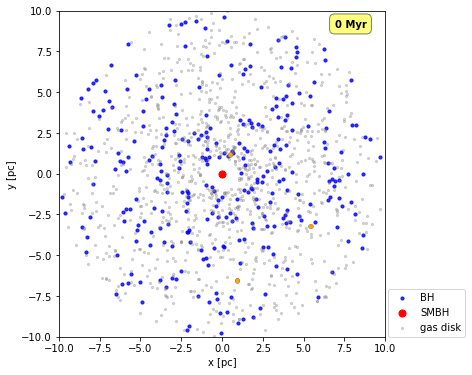



Evolved to t = 1 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH168'] with hardness = 1.62969299239 d = 6340.77418409 au v = 3.20974383095 kms radius = 6.65706689682 parsec and theta_z = -0.0512201086031


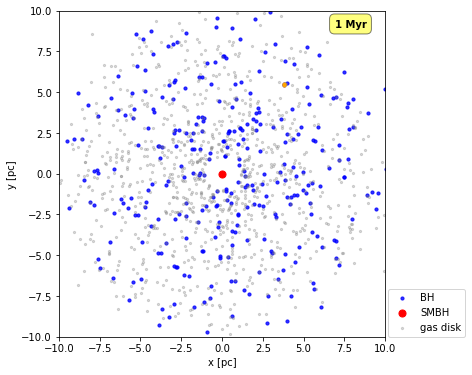



Evolved to t = 2 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.6267976883 d = 5878.42061599 au v = 3.77758911002 kms radius = 6.12747049188 parsec and theta_z = -0.0508231484806
Binary 2 is ['BH264' 'BH266'] with hardness = 0.516127439869 d = 4651.24165664 au v = 6.29053527831 kms radius = 2.96349230652 parsec and theta_z = -0.346346846529


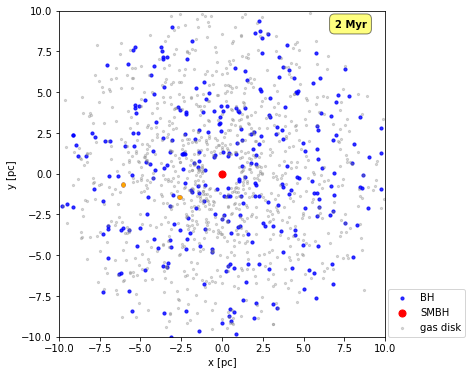



Evolved to t = 3 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.69527727533 d = 5633.93806998 au v = 3.87794566913 kms radius = 6.40996399273 parsec and theta_z = -0.0626998422854


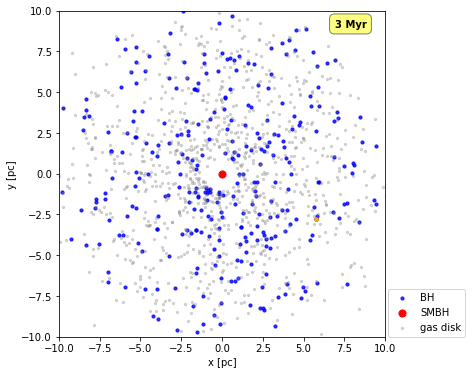



Evolved to t = 4 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.6722887851 d = 7353.88250859 au v = 1.65693244022 kms radius = 6.51572529066 parsec and theta_z = -0.323641123005


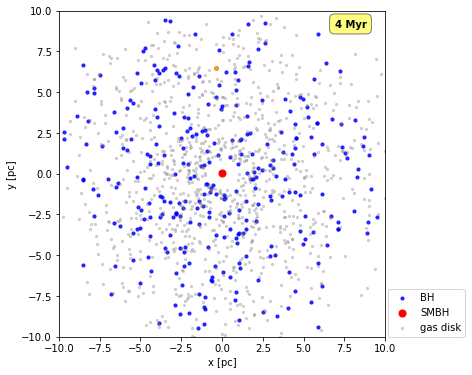



Evolved to t = 5 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.68207724969 d = 7621.69778372 au v = 0.996454080729 kms radius = 6.14668604638 parsec and theta_z = -0.211073023648
Binary 2 is ['BH149' 'BH244'] with hardness = 0.536498021457 d = 17098.2507902 au v = 2.0226921364 kms radius = 6.38233741897 parsec and theta_z = -0.0233253969079


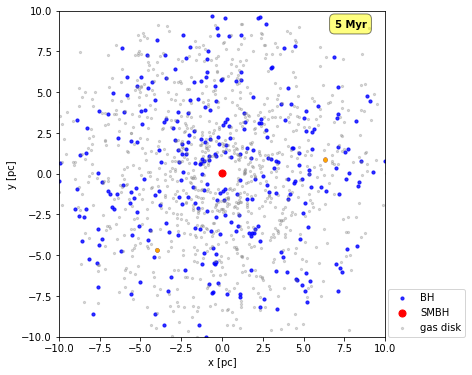



Evolved to t = 6 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH149' 'BH244'] with hardness = 0.583605056843 d = 11592.3509708 au v = 3.30690219221 kms radius = 6.68514746188 parsec and theta_z = -0.38463219822
Binary 2 is ['BH168' 'BH291'] with hardness = 1.6944873354 d = 6803.82822292 au v = 2.35354887601 kms radius = 5.53077196053 parsec and theta_z = 0.0200329798152


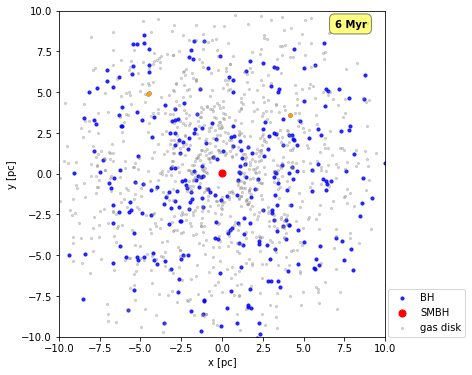



Evolved to t = 7 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH149' 'BH244'] with hardness = 0.656870684782 d = 15795.452607 au v = 1.58155786375 kms radius = 6.32989603187 parsec and theta_z = -0.270133235895
Binary 2 is ['BH200' 'BH242'] with hardness = 0.52603439685 d = 11371.1890378 au v = 3.01982054983 kms radius = 4.94168411855 parsec and theta_z = -0.0531341074022
Binary 3 is ['BH206' 'BH291'] with hardness = 2.07721811506 d = 3935.62595666 au v = 5.16125321604 kms radius = 5.56344907583 parsec and theta_z = 0.853363157906


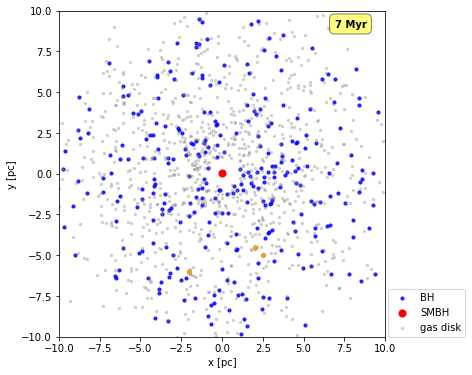



Evolved to t = 8 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.13760172089 d = 2552.50185489 au v = 8.21514438882 kms radius = 5.1055501887 parsec and theta_z = 0.853773878868


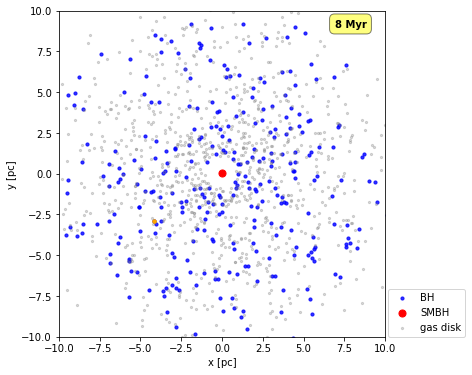



Evolved to t = 9 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.29905500563 d = 3906.29989536 au v = 4.64778548015 kms radius = 5.01462489721 parsec and theta_z = 0.817440927895
Binary 2 is ['BH242' 'BH200'] with hardness = 0.574326067471 d = 17615.7924614 au v = 0.444826565321 kms radius = 6.03975611904 parsec and theta_z = 0.374661001541


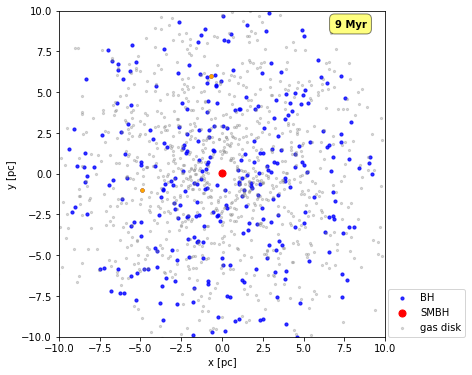



Evolved to t = 10 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.35150161519 d = 3416.70606279 au v = 5.70227259683 kms radius = 4.82923652382 parsec and theta_z = 0.765363376065
Binary 2 is ['BH200' 'BH242'] with hardness = 0.604839733655 d = 8362.09161396 au v = 3.90640420937 kms radius = 5.29335708449 parsec and theta_z = 0.183329203017


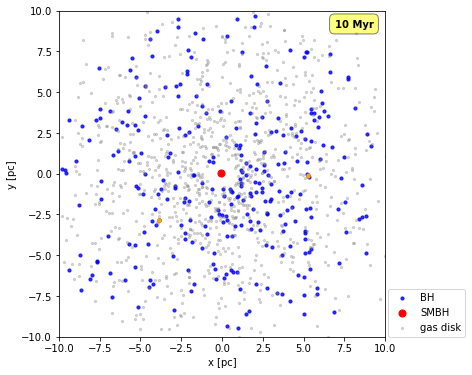



Evolved to t = 11 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.32824535556 d = 3371.04211556 au v = 5.80678747456 kms radius = 4.99141851 parsec and theta_z = 0.727292145144
Binary 2 is ['BH200' 'BH242'] with hardness = 0.595441274171 d = 6521.23437101 au v = 4.86541550078 kms radius = 5.13577508451 parsec and theta_z = 0.049597939144


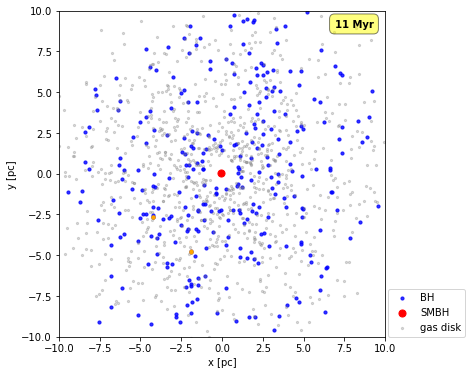



Evolved to t = 12 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.36449331699 d = 2614.54516775 au v = 7.68084800523 kms radius = 5.44917625609 parsec and theta_z = 0.709462466668
Binary 2 is ['BH242' 'BH200'] with hardness = 0.562941949981 d = 16994.480872 au v = 1.10400446114 kms radius = 6.14225879739 parsec and theta_z = 0.368066167715


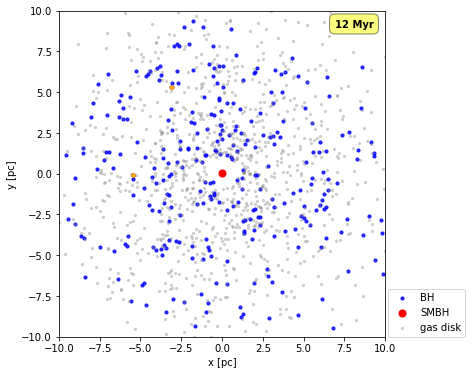



Evolved to t = 13 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.32981307741 d = 3327.08140237 au v = 5.86945102422 kms radius = 5.37702147186 parsec and theta_z = 0.686840685003
Binary 2 is ['BH161' 'BH112'] with hardness = 0.634117407302 d = 21380.4467846 au v = 0.806111203711 kms radius = 2.23413874955 parsec and theta_z = -0.570424639903
Binary 3 is ['BH100' 'BH262'] with hardness = 1.16465928644 d = 3835.21938377 au v = 5.69602446817 kms radius = 1.15058414675 parsec and theta_z = 0.337304475747
Binary 4 is ['BH242' 'BH200'] with hardness = 0.63827035247 d = 3224.28422948 au v = 7.82457848119 kms radius = 5.2741532022 parsec and theta_z = 0.158823545745


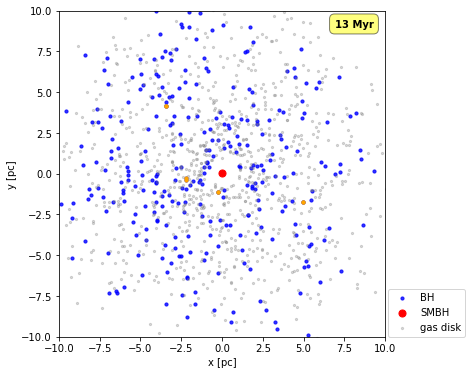



Evolved to t = 14 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.38747581495 d = 3119.86961466 au v = 6.32122680353 kms radius = 5.58717276351 parsec and theta_z = 0.69044527857


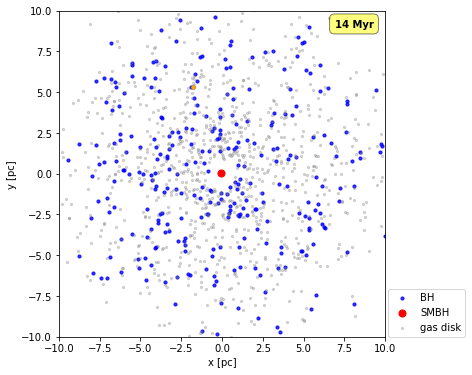



Evolved to t = 15 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.35622489963 d = 2167.96575065 au v = 9.0552093927 kms radius = 5.18377142468 parsec and theta_z = 0.711112420452


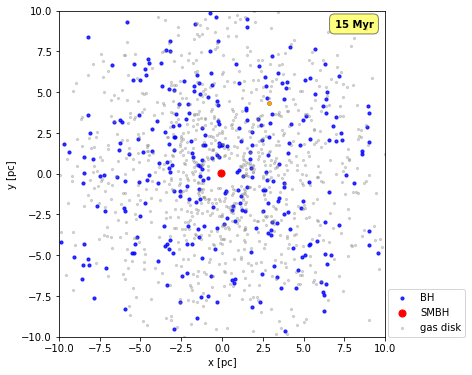



Evolved to t = 16 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.56424721637 d = 3788.45980597 au v = 4.28954632829 kms radius = 4.90318601655 parsec and theta_z = 0.721414454663


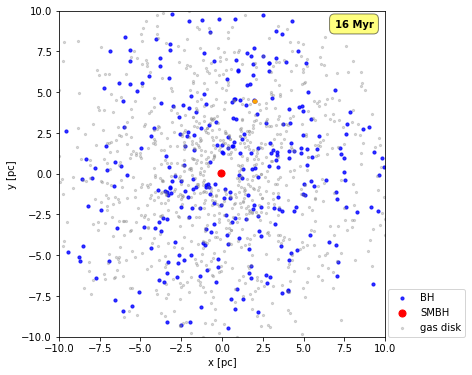



Evolved to t = 17 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.59050691106 d = 3421.973138 au v = 5.16085441944 kms radius = 5.00274827253 parsec and theta_z = 0.765789809622


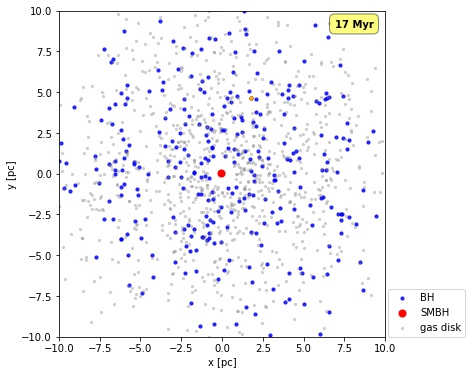



Evolved to t = 18 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.54135536299 d = 1057.99103406 au v = 14.9239361359 kms radius = 5.0748357477 parsec and theta_z = 0.790305391357


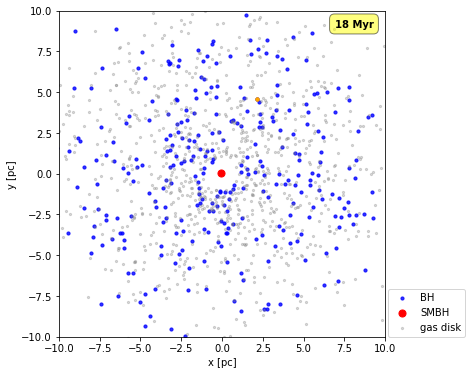



Evolved to t = 19 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.37446016892 d = 1276.85380712 au v = 12.2397144909 kms radius = 4.97383894898 parsec and theta_z = 0.427593379696


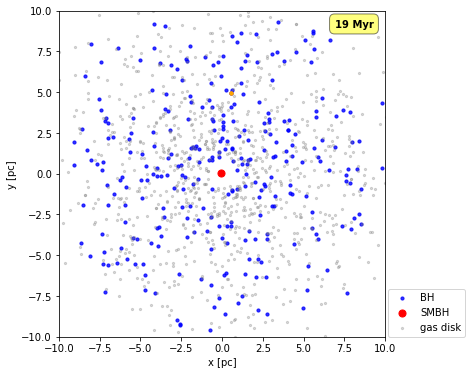



Evolved to t = 20 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.25819718158 d = 1120.48469955 au v = 13.4782923103 kms radius = 4.98884907828 parsec and theta_z = 0.452955619723


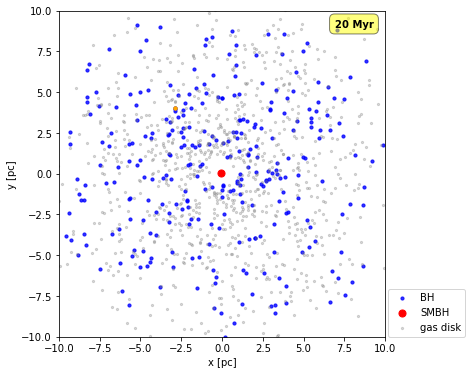



Evolved to t = 21 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.29016102816 d = 2380.11307711 au v = 6.59726927049 kms radius = 4.78684077374 parsec and theta_z = 0.487854875107


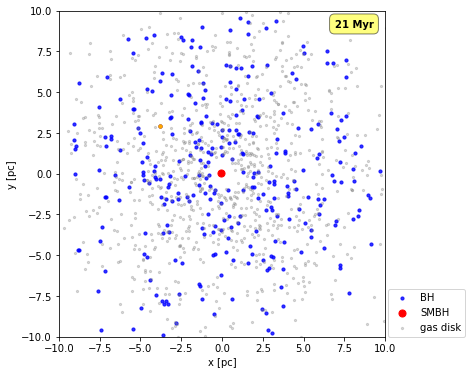



Evolved to t = 22 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.3391978796 d = 2791.99815934 au v = 5.0344612625 kms radius = 4.60061193209 parsec and theta_z = 0.531039934202


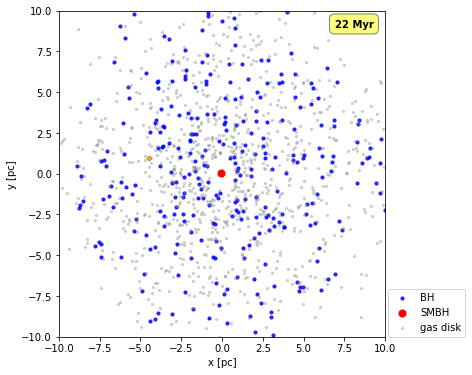



Evolved to t = 23 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.42831544192 d = 2652.86320648 au v = 5.49517868433 kms radius = 4.56070710795 parsec and theta_z = 0.600596345412


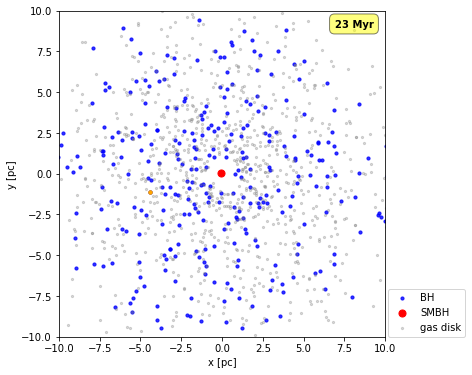



Evolved to t = 24 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.35850526496 d = 1967.20174612 au v = 8.28343739004 kms radius = 4.58665082328 parsec and theta_z = 0.688597080259


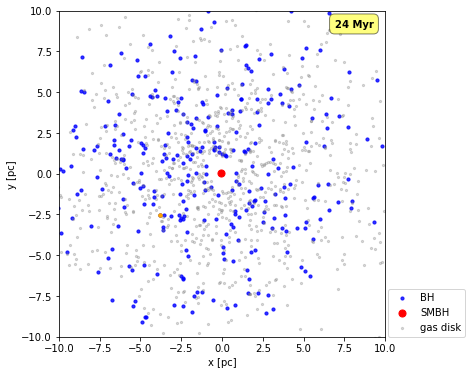



Evolved to t = 25 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.41143569279 d = 3059.38853269 au v = 3.93445809789 kms radius = 4.80487155633 parsec and theta_z = 0.747299887932


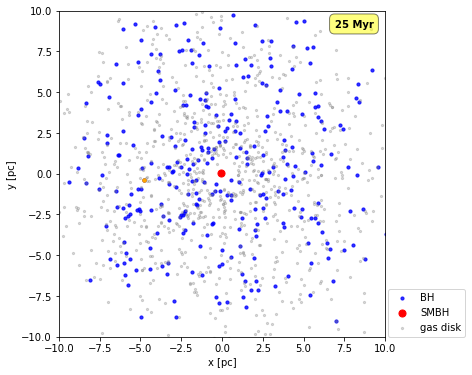



Evolved to t = 26 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.30856596836 d = 700.425352523 au v = 18.3742614085 kms radius = 4.65206596151 parsec and theta_z = 0.725234553975


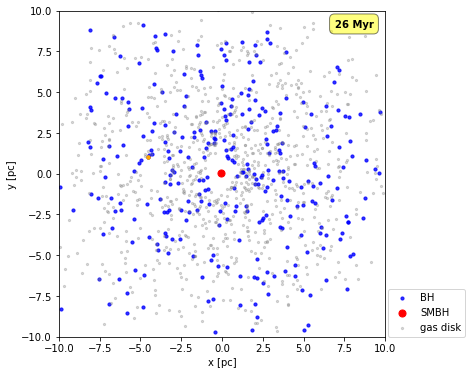



Evolved to t = 27 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.18574317987 d = 2230.58739318 au v = 7.46300203155 kms radius = 4.7017593192 parsec and theta_z = -0.0454140350631


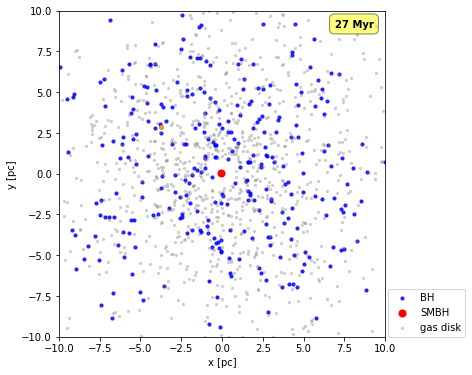



Evolved to t = 28 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.21707489315 d = 1939.52766432 au v = 8.68010719099 kms radius = 4.57487596209 parsec and theta_z = -0.0424728362695


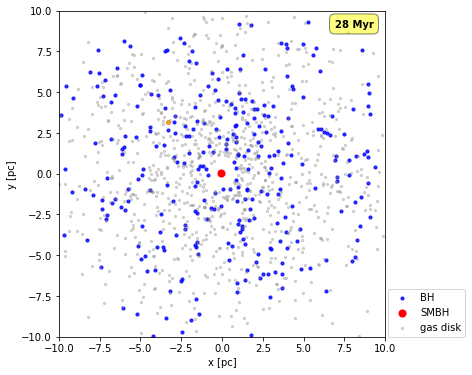



Evolved to t = 29 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.08248067791 d = 1888.07741531 au v = 8.91331443684 kms radius = 4.3967366673 parsec and theta_z = -0.0424529497102


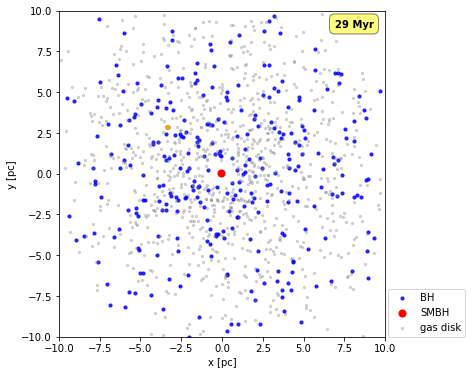



Evolved to t = 30 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.17466572154 d = 1238.00999976 au v = 12.6852560898 kms radius = 4.2698074288 parsec and theta_z = -0.0597087636688


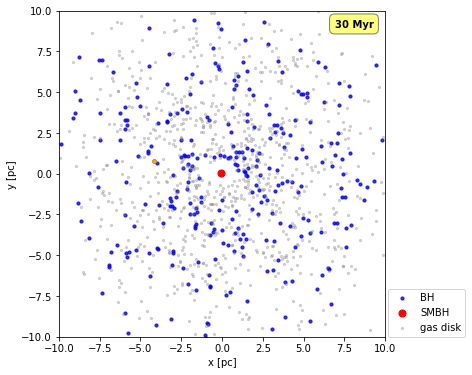



Evolved to t = 31 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.13574307339 d = 1610.39105572 au v = 10.3037535035 kms radius = 4.41601144171 parsec and theta_z = -0.0660018098518


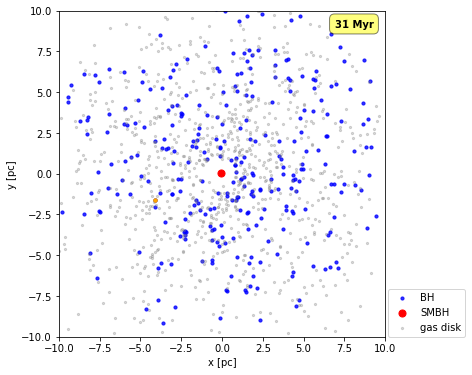



Evolved to t = 32 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.19606603019 d = 2209.29570174 au v = 7.53680909449 kms radius = 4.80170863474 parsec and theta_z = -0.0622695309929


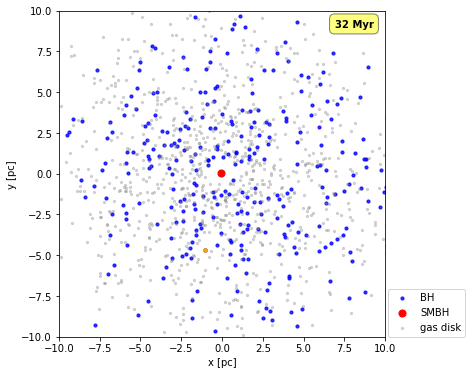



Evolved to t = 33 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.22062561924 d = 2438.89280936 au v = 6.65068049559 kms radius = 4.94041334829 parsec and theta_z = -0.112507522138


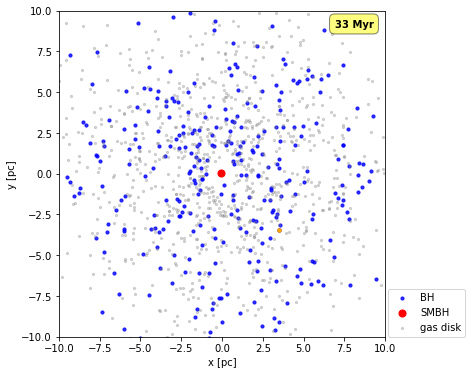



Evolved to t = 34 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.09107104677 d = 446.287809562 au v = 24.1035095911 kms radius = 4.920230389 parsec and theta_z = 0.0349234469775


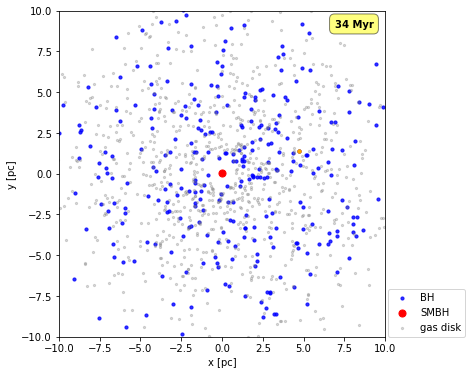



Evolved to t = 35 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.91569792668 d = 3162.55053306 au v = 1.03876360517 kms radius = 4.30493518422 parsec and theta_z = -0.140484073114


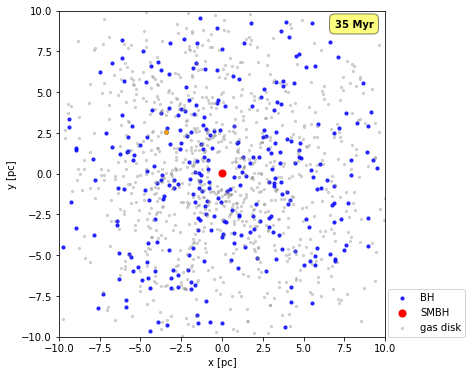



Evolved to t = 36 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.87607055777 d = 1141.8223264 au v = 12.8029730365 kms radius = 4.11924387822 parsec and theta_z = -0.060322826377


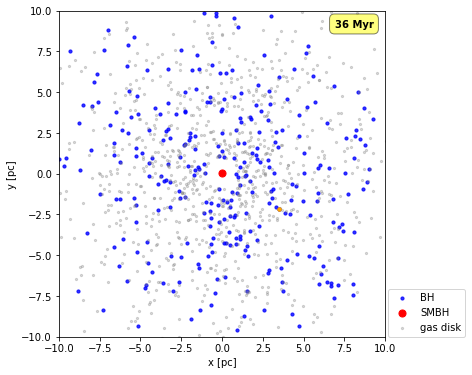



Evolved to t = 37 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.89797473448 d = 2868.92829683 au v = 3.0984337132 kms radius = 4.2076302402 parsec and theta_z = -0.0391712852739
Binary 2 is ['BH224' 'BH232'] with hardness = 0.826151292967 d = 15731.6995715 au v = 1.5973072997 kms radius = 3.74228461205 parsec and theta_z = 0.336990801604


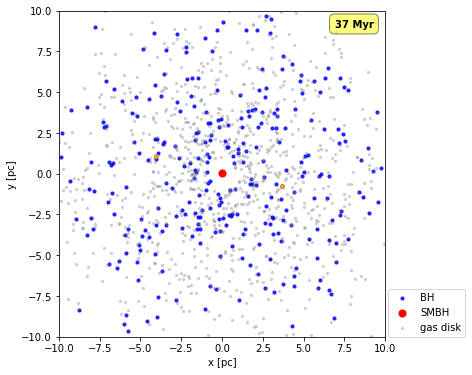



Evolved to t = 38 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.90108671569 d = 2517.06835712 au v = 4.87247351246 kms radius = 4.15803316676 parsec and theta_z = -0.0290301164496


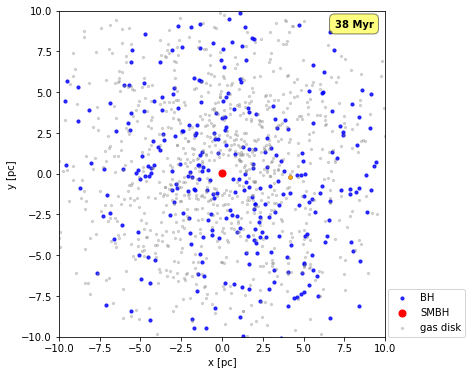



Evolved to t = 39 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.9105983713 d = 1234.78562549 au v = 11.9857494561 kms radius = 3.95784994188 parsec and theta_z = -0.0368373119393


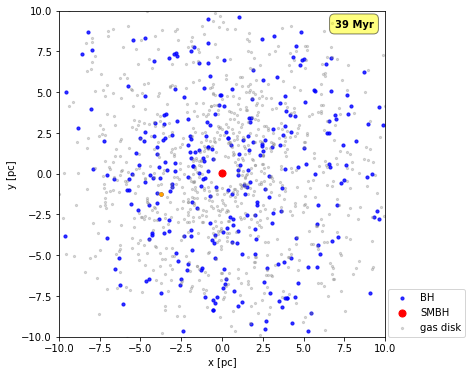



Evolved to t = 40 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.88815555997 d = 2836.66176302 au v = 3.15483498576 kms radius = 3.98873723991 parsec and theta_z = -0.0280044897434


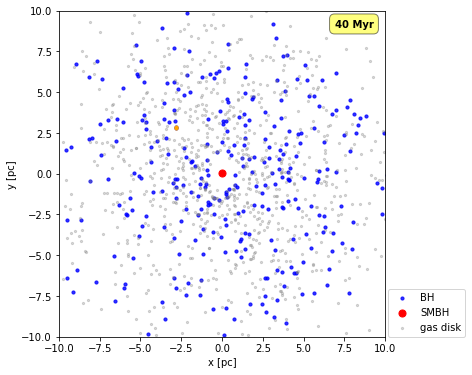



Evolved to t = 41 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.89545321604 d = 2057.92303137 au v = 6.98410307303 kms radius = 4.04889124862 parsec and theta_z = -0.00564775845506


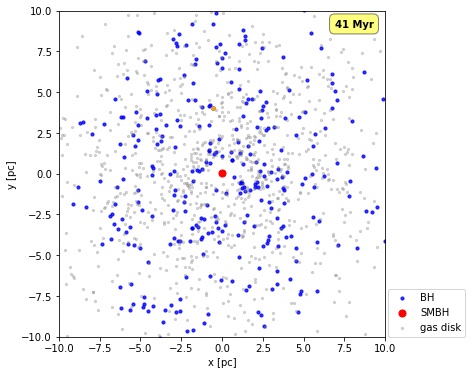



Evolved to t = 42 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.47473025422 d = 2329.78000188 au v = 4.24254773881 kms radius = 4.16314660473 parsec and theta_z = 0.143922451918


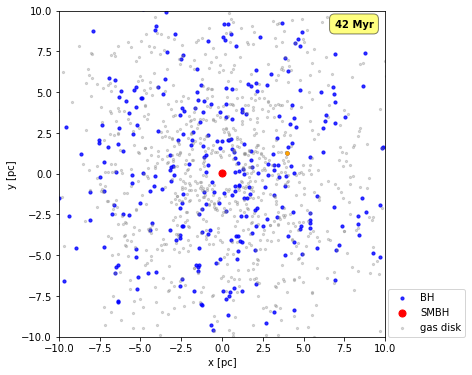



Evolved to t = 43 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.63402379455 d = 2438.50843651 au v = 3.21161896031 kms radius = 4.00458912234 parsec and theta_z = 0.0456218516286


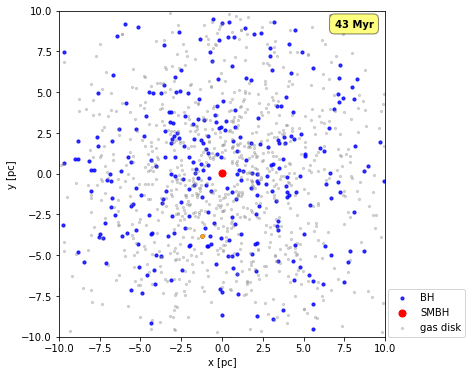



Evolved to t = 44 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.6080598291 d = 2226.71797052 au v = 4.63444820962 kms radius = 4.37820571542 parsec and theta_z = 0.0573780357508


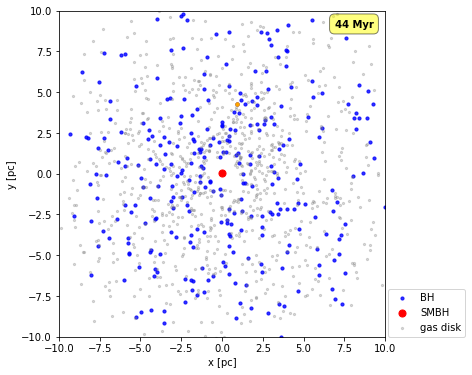



Evolved to t = 45 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.60609573194 d = 771.284630905 au v = 16.4075455515 kms radius = 4.31141076739 parsec and theta_z = 0.0557048502422


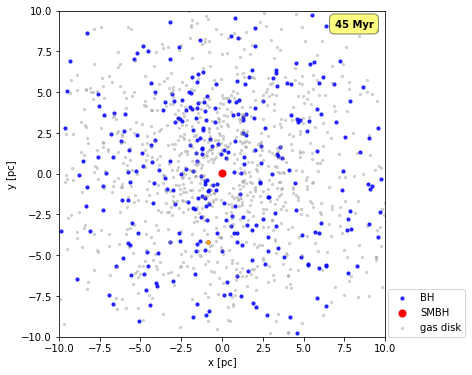



Evolved to t = 46 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.71766177285 d = 1993.07012362 au v = 6.06604477957 kms radius = 4.57573230304 parsec and theta_z = 0.0591631391707


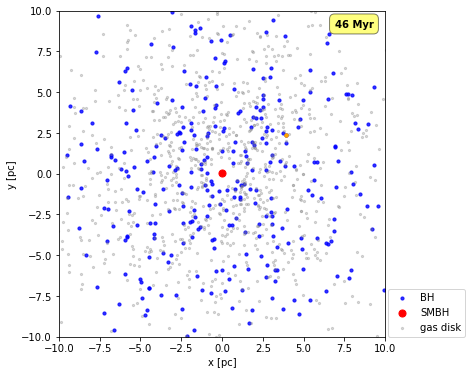



Evolved to t = 47 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.59906031384 d = 2039.30949792 au v = 5.77492728625 kms radius = 4.17543440188 parsec and theta_z = 0.0576015560549


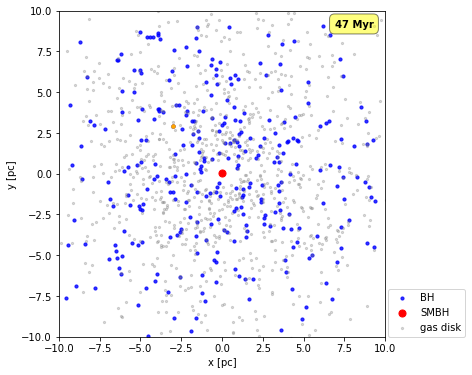



Evolved to t = 48 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.694024913 d = 2019.6857845 au v = 5.89721826982 kms radius = 4.56002148893 parsec and theta_z = 0.0585345896695


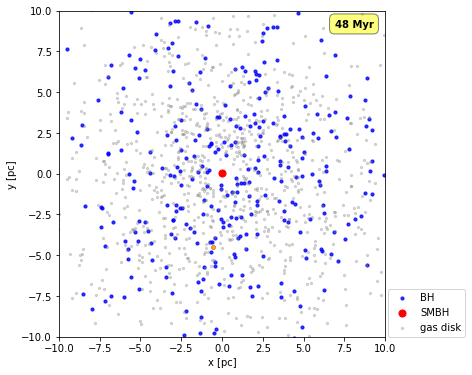



Evolved to t = 49 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70578047416 d = 1988.76019876 au v = 6.07369054102 kms radius = 4.46455194532 parsec and theta_z = 0.0671638087065


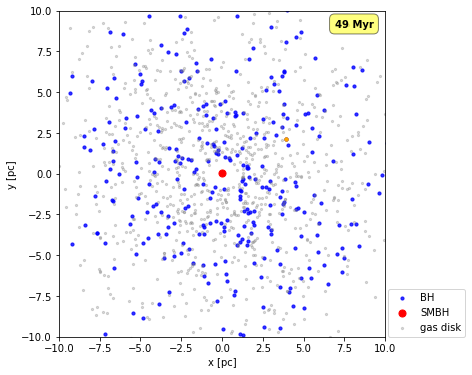



Evolved to t = 50 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.58255593939 d = 1873.04884272 au v = 6.7754659062 kms radius = 4.03036863912 parsec and theta_z = 0.0819629014069


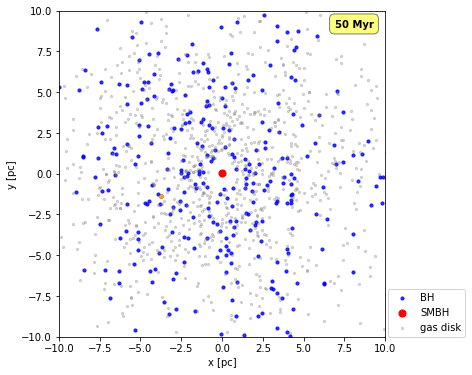



Evolved to t = 51 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.76054120993 d = 1753.44313376 au v = 7.51310056501 kms radius = 4.80207204518 parsec and theta_z = 0.107068749236


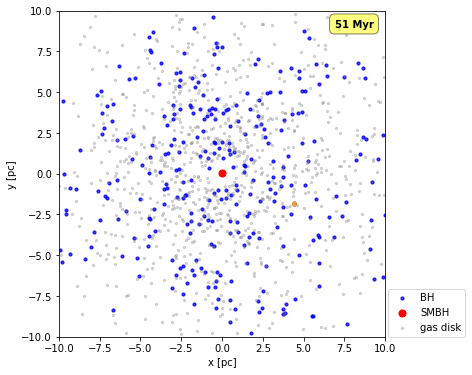



Evolved to t = 52 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.58392100915 d = 2369.88335676 au v = 3.59202521194 kms radius = 4.16497070007 parsec and theta_z = 0.16144338814


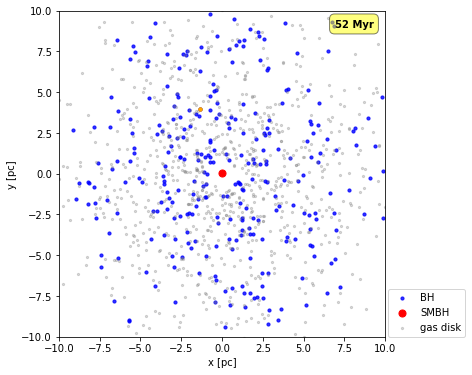



Evolved to t = 53 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.57991589521 d = 700.909433895 au v = 17.5415090026 kms radius = 4.4783049528 parsec and theta_z = 0.293179188444


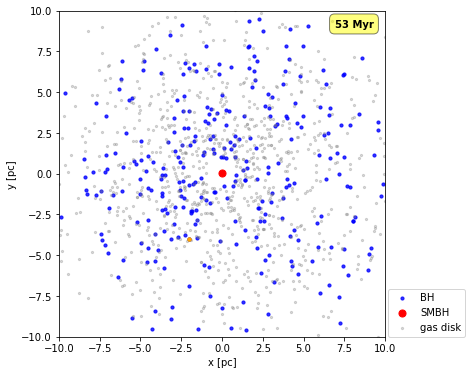



Evolved to t = 54 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.69535179456 d = 2470.44020995 au v = 2.83405405479 kms radius = 4.40333417668 parsec and theta_z = 0.666520952982


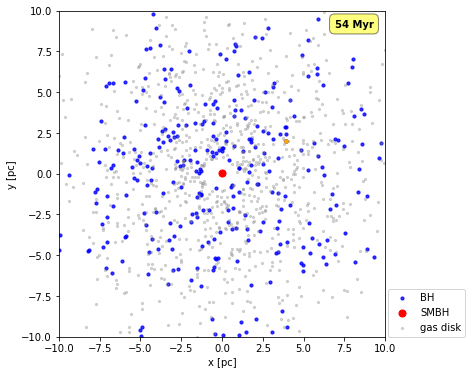



Evolved to t = 55 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.64528778035 d = 2539.4131069 au v = 1.95033106308 kms radius = 4.16903387759 parsec and theta_z = 0.559701294882


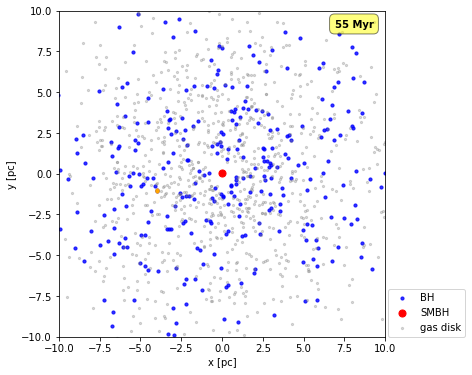



Evolved to t = 56 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.5742630219 d = 1172.03197036 au v = 11.7495438276 kms radius = 4.48112695793 parsec and theta_z = 0.390020467307


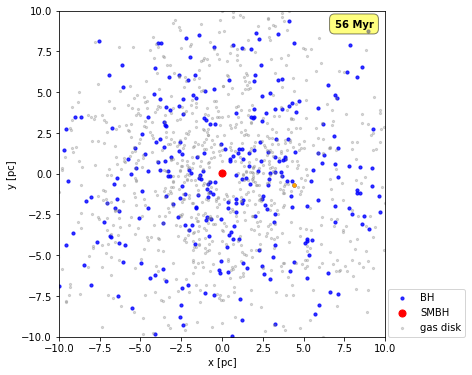



Evolved to t = 57 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.6594848408 d = 2099.56089635 au v = 5.16957977936 kms radius = 4.04373840498 parsec and theta_z = 0.324495214175


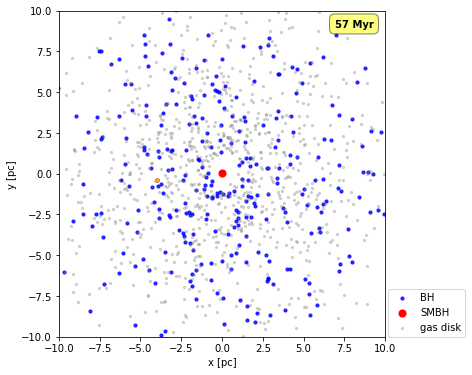



Evolved to t = 58 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.88916214668 d = 1460.80968054 au v = 9.3526784093 kms radius = 4.32941702761 parsec and theta_z = 0.290441587346


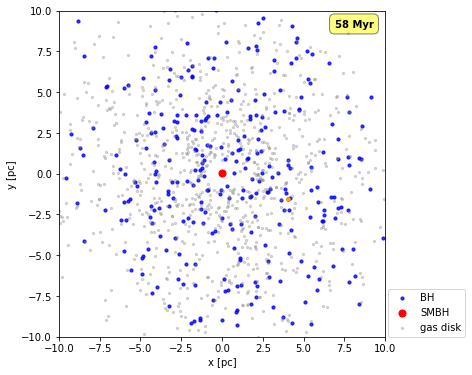



Evolved to t = 59 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.67610855273 d = 1271.19516007 au v = 10.8275942751 kms radius = 4.17821603233 parsec and theta_z = 0.272219299535


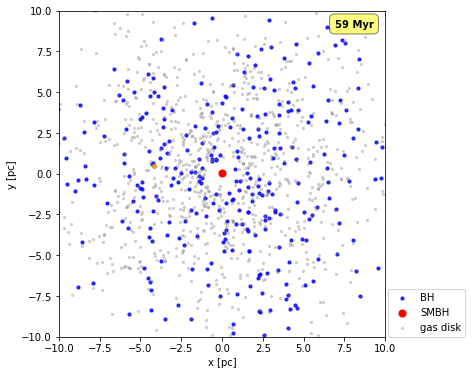



Evolved to t = 60 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.84010584705 d = 1781.11071082 au v = 7.16302526288 kms radius = 4.53805447066 parsec and theta_z = 0.26101693731


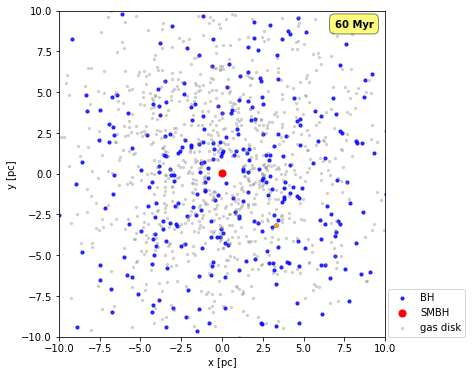



Evolved to t = 61 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.76163840596 d = 824.542058485 au v = 15.5577533635 kms radius = 4.90816039065 parsec and theta_z = 0.238536086323


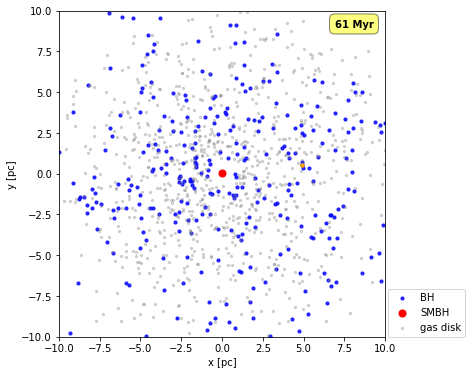



Evolved to t = 62 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.77526634524 d = 1557.37313767 au v = 8.66867129129 kms radius = 4.88921596165 parsec and theta_z = 0.238539712578


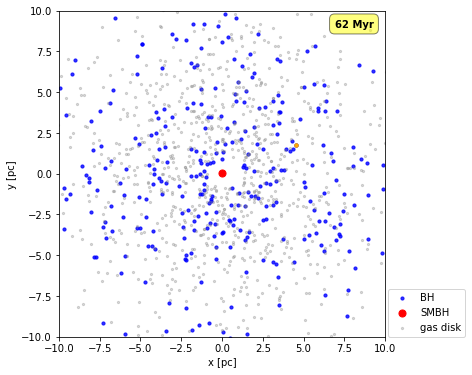



Evolved to t = 63 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.7788646616 d = 1630.83907659 au v = 8.1459259427 kms radius = 4.44909573555 parsec and theta_z = 0.220635937818


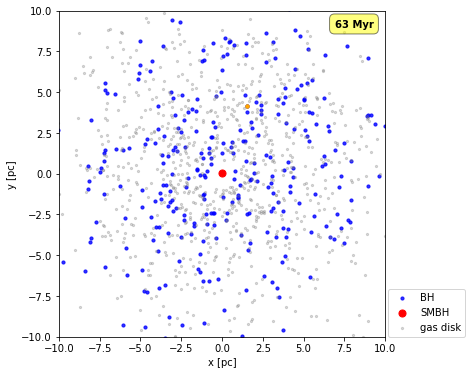



Evolved to t = 64 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.63091020095 d = 1612.70317981 au v = 8.2528125295 kms radius = 4.1519971329 parsec and theta_z = 0.224843558042


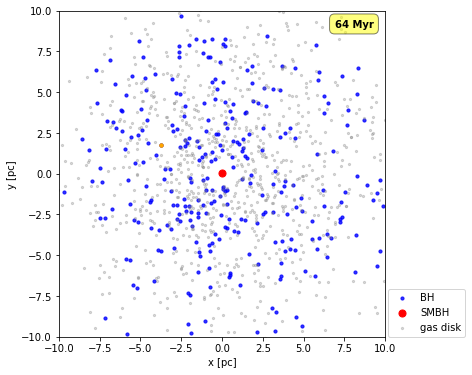



Evolved to t = 65 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.77817021228 d = 1383.25717789 au v = 9.90880947417 kms radius = 4.46012210997 parsec and theta_z = 0.219397183384


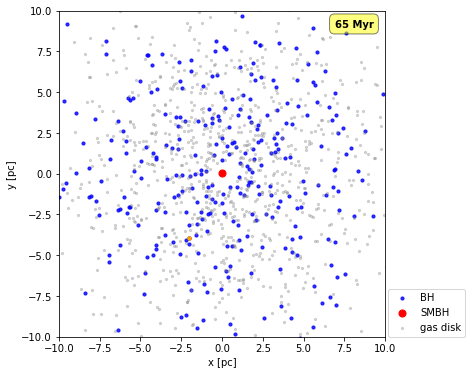



Evolved to t = 66 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70621816065 d = 929.570100676 au v = 14.1889931759 kms radius = 4.8511856233 parsec and theta_z = 0.2248217337


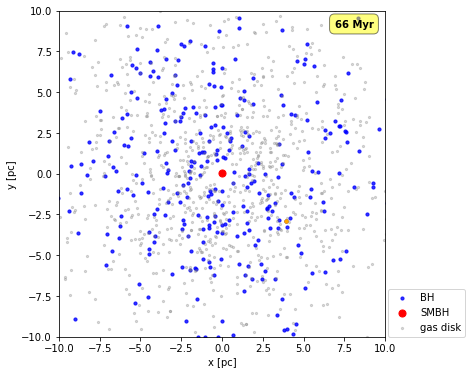



Evolved to t = 67 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70098385178 d = 889.863844112 au v = 14.6719590955 kms radius = 4.78458683005 parsec and theta_z = 0.222396577598


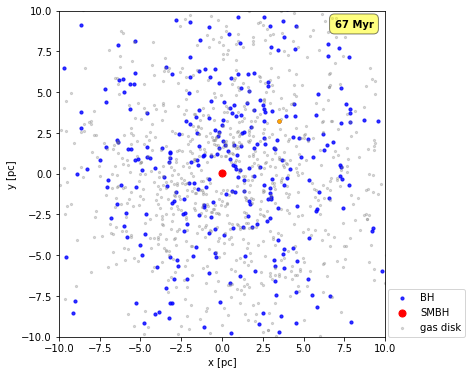



Evolved to t = 68 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.87122667531 d = 1569.54041506 au v = 8.53017319517 kms radius = 4.2397924435 parsec and theta_z = 0.231533921921


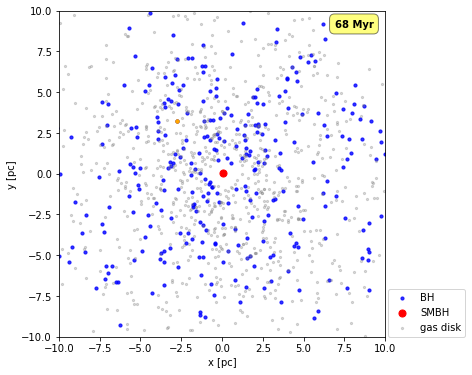



Evolved to t = 69 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.6586761291 d = 1874.3195406 au v = 6.53169416923 kms radius = 4.31113078065 parsec and theta_z = 0.232744780945


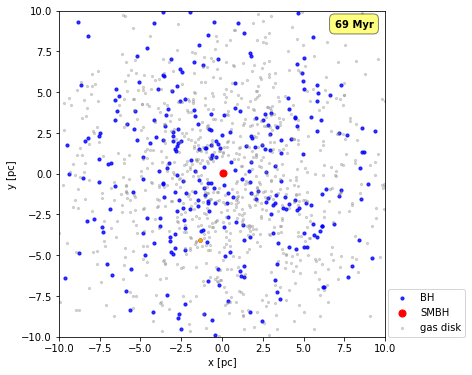



Evolved to t = 70 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.64469619666 d = 1990.1140234 au v = 5.80151114535 kms radius = 5.03624838051 parsec and theta_z = 0.252426593122


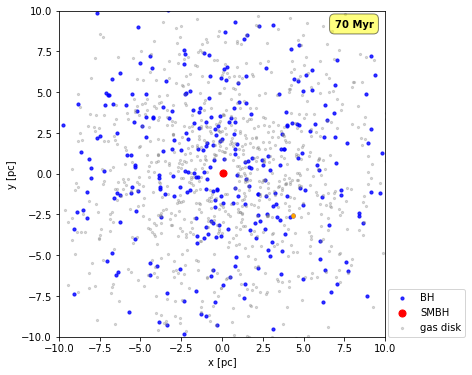



Evolved to t = 71 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.89349829222 d = 2086.74393394 au v = 5.06120742612 kms radius = 4.98610620152 parsec and theta_z = 0.331194232446


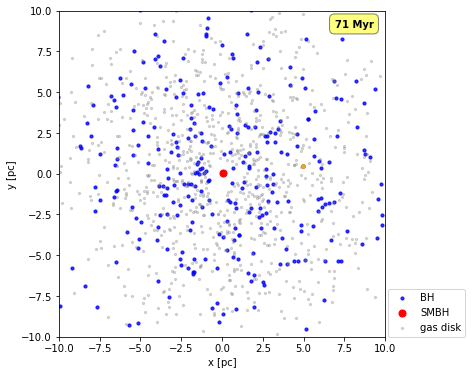



Evolved to t = 72 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.65762192258 d = 1807.0498764 au v = 6.86961361488 kms radius = 4.92727950051 parsec and theta_z = 0.365548767831


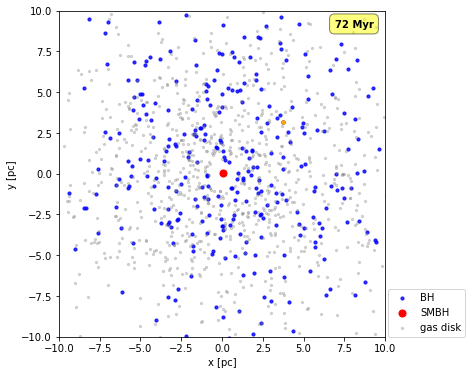



Evolved to t = 73 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.87638948009 d = 2243.58511262 au v = 3.94079575684 kms radius = 4.79655375164 parsec and theta_z = 0.425022405058


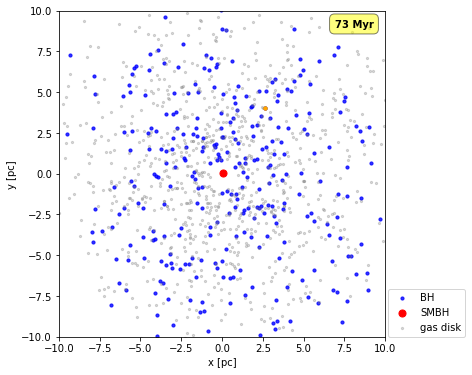



Evolved to t = 74 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH39' 'BH218'] with hardness = 0.732401763281 d = 5952.27263749 au v = 6.31926454864 kms radius = 3.92374864102 parsec and theta_z = -0.670188168561
Binary 2 is ['BH291' 'BH66'] with hardness = 4.80553500596 d = 2311.67193761 au v = 3.3914540252 kms radius = 4.76418143064 parsec and theta_z = 0.507665399933


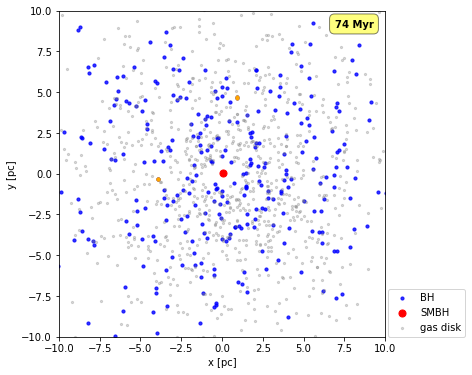



Evolved to t = 75 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.88079675462 d = 1037.7598368 au v = 12.9026734655 kms radius = 4.80938999682 parsec and theta_z = 0.609271476505


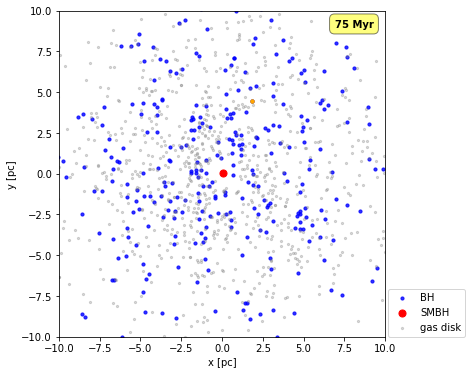



Evolved to t = 76 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.82325711978 d = 1235.45462186 au v = 11.0002384603 kms radius = 4.95361402959 parsec and theta_z = 0.705830687684


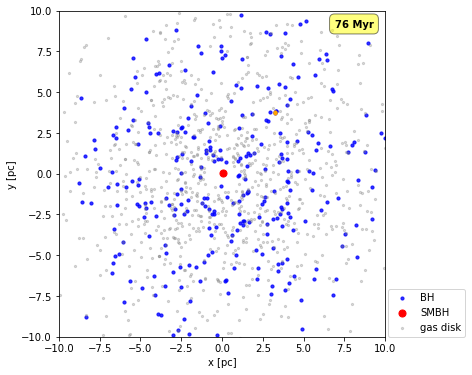



Evolved to t = 77 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.96535435309 d = 802.576053429 au v = 15.7504941294 kms radius = 5.10310672119 parsec and theta_z = 0.714959352527


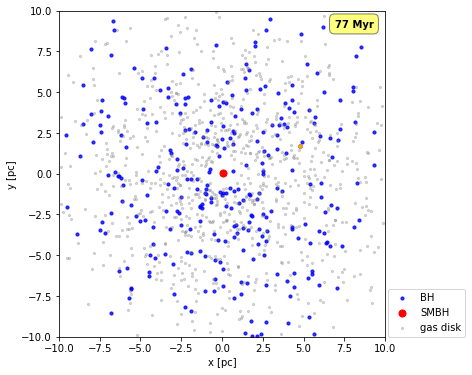



Evolved to t = 78 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.95471688964 d = 1890.28778932 au v = 6.16900074449 kms radius = 5.35525338412 parsec and theta_z = 0.629037886683


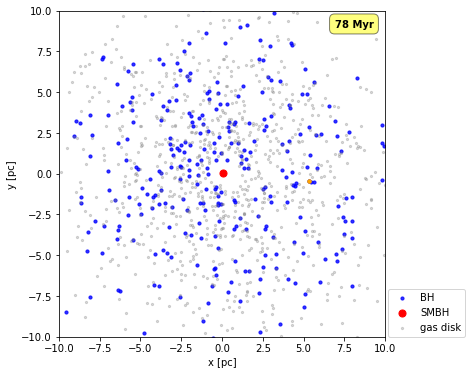



Evolved to t = 79 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.83481346678 d = 1956.75323778 au v = 5.69652919635 kms radius = 5.23981198906 parsec and theta_z = 0.538526809522


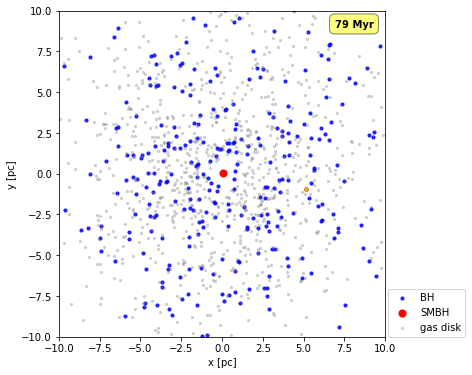

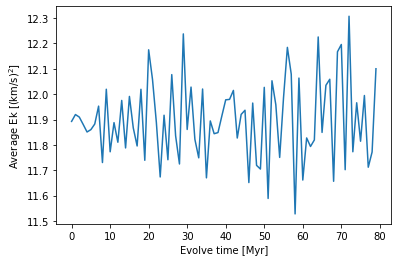

In [9]:
evolve_time_list_b = [] | units.Myr 
average_Ek_list_b = [] | units.kms**2

binary_b = []

bodies_x_b = []
bodies_y_b = []

model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

# def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies, end_time):
        
gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

while model_time < end_time:    

    gravhydro.evolve_model(model_time)
    resolve_collision(stopping_condition, gravityA, Nbody) # Collision detection
        
    channel["to_BHs"].copy()
    channel["to_gasdisk"].copy()
        
    bodies_x_b.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    bodies_y_b.append(bodies.y.value_in(units.pc))

    if model_time.value_in(units.Myr)>=x:
        x+=1
        print("Evolved to t =", int(model_time.number), "Myr",
                "\nBH number =", len(BHdisk))
            
        plot()
        scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
            
        b, average_Ek = get_binaries(Nbody) # Binaries detection
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
                      "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
                      "v =", (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms),
                     "radius =", b[i].center_of_mass().length().in_(units.pc),
                     'and theta_z =', b[i].thetaz[0])
                
                binary_b.append([b[i].mass.sum().number, b[i].hardness[0], 
                                 (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
                               b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
                                (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])
                
                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='g') 
                        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n")
            
        evolve_time_list_b.append(model_time)
        average_Ek_list_b.append(average_Ek)
        
    model_time += dt
        


gravityA.stop()
hydro.stop()

# end_time = 10 | units.Myr
# gravity_hydro_bridge(gravityA, hydro, gravhydro, 
#                      bodies, end_time)

plt.figure()
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Animation 

In [ ]:
# Animation for Nbody
import os
import matplotlib.animation as animation
from amuse.io import read_set_from_file

def animate(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    
    for i in range(1, len(x[0])):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Nbody/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate(bodies_x, bodies_y)

In [ ]:
# Animation for bridge
def animate_b(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    Alpha = [1]
    
    for i in range(1, len(BHdisk)+1):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        Alpha.append(1)
    for i in range(len(BHdisk)+1, len(bodies)):
        colormap.append('gray')
        size.append(10)
        edgecolor.append('gray')
        Alpha.append(0.3)
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor, alpha=Alpha)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Bridge/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate_b(bodies_x_b, bodies_y_b)

## Analysis

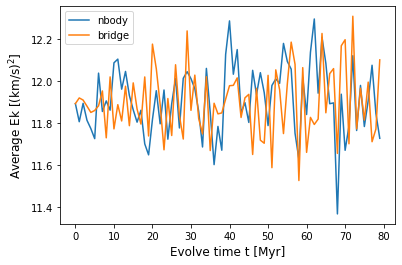

In [12]:
# Compare average kinetic energy
plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2), label="nbody")
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2), label="bridge")
plt.xlabel('Evolve time t [Myr]',fontsize=12)
plt.ylabel('Average Ek [(km/s)$^2$]',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/average_Ek of Nbody and Bridge simulation.png')
plt.show()

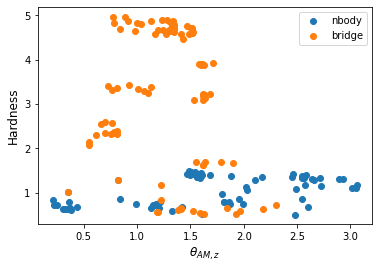

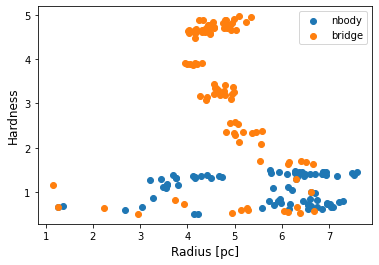

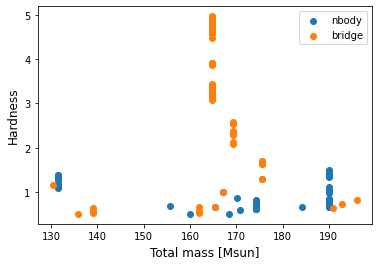

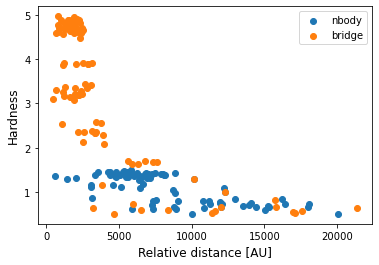

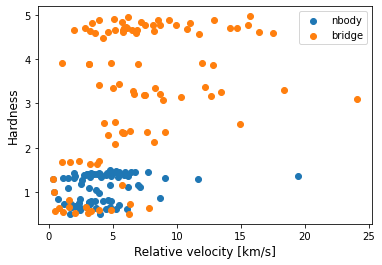

In [39]:
# Binary properties
binary_n = np.array(binary_n)
binary_b = np.array(binary_b)
mass_n, mass_b = binary_n[:,0], binary_b[:,0]
hardness_n, hardness_b = binary_n[:,1], binary_b[:,1]
d_n, d_b = binary_n[:,2], binary_b[:,2]
radius_n, radius_b = binary_n[:,3], binary_b[:,3]
thetaz_n, thetaz_b = binary_n[:,4], binary_b[:,4]
v_n, v_b = binary_n[:,5], binary_b[:,5]

plt.figure()
scatter(np.arccos(thetaz_n), hardness_n, label="nbody")
scatter(np.arccos(thetaz_b), hardness_b, label="bridge")
plt.xlabel(r'$\theta_{AM, z}$', fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. thetaz of binaries.png')
plt.show()

plt.figure()
scatter(radius_n, hardness_n, label="nbody")
scatter(radius_b, hardness_b, label="bridge")
plt.xlabel('Radius [pc]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. orbital radius of binaries.png')
plt.show()

plt.figure()
scatter(mass_n, hardness_n, label="nbody")
scatter(mass_b, hardness_b, label="bridge")
plt.xlabel('Total mass [Msun]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. total mass of binaries.png')
plt.show()

plt.figure()
scatter(d_n, hardness_n, label="nbody")
scatter(d_b, hardness_b, label="bridge")
plt.xlabel('Relative distance [AU]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. relative distance of binaries.png')
plt.show()

plt.figure()
scatter(v_n, hardness_n, label="nbody")
scatter(v_b, hardness_b, label="bridge")
plt.xlabel('Relative velocity [km/s]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. relative velocity of binaries.png')
plt.show()

In [16]:
print("Nbody soft/hard binaries number in", end_time, "is", len(binary_n))
print("Bridge soft/hard binaries number in", end_time, "is", len(binary_b))

Nbody soft/hard binaries number in 80 Myr is 81
Bridge soft/hard binaries number in 80 Myr is 96


In [59]:
BH_init = []
for i in range(len(BHdisk0)):
    BH_init.append([BHdisk0.mass[i].value_in(units.MSun), BHdisk0.name[i], BHdisk0.radius[i].value_in(units.m),
                   BHdisk0.vx[i].value_in(units.kms),BHdisk0.vy[i].value_in(units.kms),BHdisk0.vz[i].value_in(units.kms),
                   BHdisk0.x[i].value_in(units.pc),BHdisk0.y[i].value_in(units.pc),BHdisk0.z[i].value_in(units.pc)])
    
BH_init = np.array(BH_init)
np.savetxt("BH_init.txt", BH_init, fmt='%s', delimiter=',')

import os
with open('BH_init.txt', 'r+') as f:
 content = f.read()  
 f.seek(0, 0)
 f.write('#mass/MSun,name,radius/m,vx/kms,vy/kms,vz/kms,x/pc,y/pc,z/pc\n'+content)